In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool, cv, CatBoostRegressor
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import optuna
from optuna.samplers import TPESampler
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
from optuna.integration import CatBoostPruningCallback
import matplotlib.pyplot as plt
import shap
import plotly.express as px
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance
import shap
import plotly.graph_objects as go
import sweetviz as sv
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_iterative_imputer
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.impute import IterativeImputer

2024-03-27 02:14:29.571821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 02:14:29.571852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 02:14:29.573165: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-27 02:14:29.580272: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 02:14:30.712834: W tensorflow/compiler/tf2

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")


Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
class_distribution_train = train_data.copy()
class_distribution_train

,MUSTERI_ID,LABEL,FLAG,PP_CINSIYET,PP_YAS,PP_MESLEK,PP_MUSTERI_SEGMENTI,PP_UYRUK,IL,SORU_YATIRIM_KARAKTERI_CVP,...,HU11,HU12,HU13,HU14,HU15,HU16,HU17,HU18,HU19,AKTIF_ILK_POLICE_RG
0,61921038d5c39a821cfed2e5e3ad88740decd1fbd6f34b...,UA,HAZIRAN,2,505,Öğretmen,105,1,34,NaN,...,0,0,0,0,0,0,0,0,0,9
1,8cd400d3897e5ff130e8e942ee1906d17531a8253d26a4...,UA,HAZIRAN,2,889,Emekli (Sosyal Güvenlik Kurumu Bilinmiyor),102,1,20,NaN,...,0,0,0,0,0,0,0,0,0,11
2,6af95ba9ebe2362a0b31b4443fb2405b11d588780c01ad...,HU19,HAZIRAN,2,578,Muhasebe,104,1,6,Yetkin,...,0,1,0,0,0,0,0,0,0,66
3,fe33e7873368d603d2a49a982619e8d61a964d7a0ef68e...,UA,MAYIS,2,648,Diğer,106,1,34,NaN,...,0,0,0,0,0,0,0,0,0,111
4,aae8411e2c335e94922290314abe1fcc81044e8071e1c8...,UA,EYLUL,2,487,İşçi,103,1,77,NaN,...,0,0,0,0,0,0,0,0,0,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852714,4a245f1a49af39319faa41668d6ee425fb71c7a75e8b22...,UA,MAYIS,1,551,İşçi,105,1,35,NaN,...,0,0,0,0,0,0,0,0,0,7
852715,2087a8e5f1f98d143011df1cccaa0331e3427b1a1e642e...,UA,HAZIRAN,2,466,Ev Hanımı,104,1,33,NaN,...,0,0,0,0,0,0,0,0,0,52
852716,8d4dccb1bd4763e909476935805d99b84e7f2098b646b7...,UA,MAYIS,1,139,İşçi,106,1,28,NaN,...,0,0,0,0,0,0,0,0,0,5
852717,e33a48c42db1da438d54da64cf59ef4acae4583bd4effc...,UA,MAYIS,2,303,NaN,106,1,20,NaN,...,0,0,0,0,0,0,0,0,0,72


In [4]:
test_data.iloc[:,13]

0           NaN
1         112.0
2         219.0
3         208.0
4           4.0
          ...  
195626    241.0
195627     11.0
195628    150.0
195629     20.0
195630      NaN
Name: SORU_EGITIM_RG, Length: 195631, dtype: float64

In [5]:
train_data.head(20)

,MUSTERI_ID,LABEL,FLAG,PP_CINSIYET,PP_YAS,PP_MESLEK,PP_MUSTERI_SEGMENTI,PP_UYRUK,IL,SORU_YATIRIM_KARAKTERI_CVP,...,HU11,HU12,HU13,HU14,HU15,HU16,HU17,HU18,HU19,AKTIF_ILK_POLICE_RG
0,61921038d5c39a821cfed2e5e3ad88740decd1fbd6f34b...,UA,HAZIRAN,2,505,Öğretmen,105,1,34,NaN,...,0,0,0,0,0,0,0,0,0,9
1,8cd400d3897e5ff130e8e942ee1906d17531a8253d26a4...,UA,HAZIRAN,2,889,Emekli (Sosyal Güvenlik Kurumu Bilinmiyor),102,1,20,NaN,...,0,0,0,0,0,0,0,0,0,11
2,6af95ba9ebe2362a0b31b4443fb2405b11d588780c01ad...,HU19,HAZIRAN,2,578,Muhasebe,104,1,6,Yetkin,...,0,1,0,0,0,0,0,0,0,66
3,fe33e7873368d603d2a49a982619e8d61a964d7a0ef68e...,UA,MAYIS,2,648,Diğer,106,1,34,NaN,...,0,0,0,0,0,0,0,0,0,111
4,aae8411e2c335e94922290314abe1fcc81044e8071e1c8...,UA,EYLUL,2,487,İşçi,103,1,77,NaN,...,0,0,0,0,0,0,0,0,0,90
5,89c8f825774b2cd43583a1cac8d3fcb06c94bedd47464a...,UA,MAYIS,1,468,Serbest Meslek,102,1,34,NaN,...,0,0,0,0,0,0,0,0,0,72
6,39142bd276bb368ca3834e6abc5f680bda1a4b94da75f2...,UA,HAZIRAN,2,223,Öğrenci,105,1,48,NaN,...,0,0,0,0,0,0,0,0,0,3
7,20e4006651b151e18068b8a9c9233bf5e61c06a98b3db7...,HU07,HAZIRAN,2,579,Diğer,105,1,34,NaN,...,0,0,0,0,0,0,0,0,0,108
8,2e61f5f693bb8361b142d79e365abd71525acff40b8261...,UA,HAZIRAN,1,436,İşçi,105,1,2,NaN,...,0,0,0,0,0,0,0,0,0,8
9,dd2d9f88a107406fe2921c427250c0d8c9546fea45eea8...,UA,HAZIRAN,1,192,NaN,106,1,6,NaN,...,0,0,0,0,0,0,0,0,0,14


In [6]:
test_data.head(30)

,MUSTERI_ID,FLAG,PP_CINSIYET,PP_YAS,PP_MESLEK,PP_MUSTERI_SEGMENTI,PP_UYRUK,IL,SORU_YATIRIM_KARAKTERI_CVP,SORU_YATIRIM_KARAKTERI_RG,...,HU11,HU12,HU13,HU14,HU15,HU16,HU17,HU18,HU19,AKTIF_ILK_POLICE_RG
0,15b29e51dff893ac19bcbc96c96d1cda0307b4e0edafcd...,KASIM,2,467,Öğretmen,103,1,1.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,100
1,7532c2d4751858dd8e7eb3f26c61af568fd3b2a6aa2f32...,KASIM,1,658,Öğretmen,106,1,54.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,111
2,47498c1c6161aea484b0eed7997846919ca9287684aee4...,KASIM,1,634,Serbest Meslek,106,1,48.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,127
3,48fe7f96c7e04326f1669b4ae5bdc5ae030da6b8c26498...,KASIM,2,638,NaN,106,1,67.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,178
4,26dbe514ebfdb7b664760c07f94d0bf0b297528cd5a358...,KASIM,1,80,Öğrenci,106,1,34.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,3
5,d854474ee38b3e83b2c6b5ccdecbfde6747581342b3544...,KASIM,2,548,İşçi,105,1,19.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,11
6,40c6dcd93e6149216a41e9bb8ab0e08fd6ad3b7bb9ab10...,KASIM,2,29,Öğrenci,106,1,34.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,8
7,3260e11b653464a0de6d85d84de2d8f063ba563e5ef317...,KASIM,2,490,Ev Hanımı,105,1,2.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,19
8,c24c505678faaa835da5e9d7f6586b1aac5afa53d0248c...,KASIM,2,132,NaN,106,1,34.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
9,b86bb1515d4bf51f47752629fb602b95bad6a167297c25...,KASIM,1,290,İşçi,103,1,31.0,NaN,NaN,...,0,0,0,0,0,0,0,1,0,12


In [7]:
urun_ozellik = pd.read_excel("Urun Ozellikleri.xlsx")
urun_ozellik

,Ürün,Branş,Grup/Ferdi,Kredili/Kredisiz,Taşınan Teminat,Biriktiren/ Koruma,Sigortas Süresi,Yenileme Fonksiyonu,Yaş Gereksinimi
0,BU01,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN
1,BU02,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,18-25
2,BU03,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN
3,BU04,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN
4,BU05,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN
5,BU06,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN
6,BU07,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN
7,BU08,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN
8,BU09,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN
9,BU10,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN


In [8]:
bolge_id = pd.read_excel("SehirlerBolgeler.xlsx")
bolge_id

,Id,SehirAd,Nufus,BolgeId,BolgeAd
0,1,Adana,2201670,1,Akdeniz Bölgesi
1,2,Adıyaman,610484,4,Güneydoğu Anadolu Bölgesi
2,3,Afyonkarahisar,714523,3,Ege Bölgesi
3,4,Ağrı,542255,2,Doğu Anadolu Bölgesi
4,5,Amasya,326351,6,Karadeniz Bölgesi
...,...,...,...,...,...
76,77,Yalova,241665,7,Marmara Bölgesi
77,78,Karabük,242347,6,Karadeniz Bölgesi
78,79,Kilis,130825,4,Güneydoğu Anadolu Bölgesi
79,80,Osmaniye,522175,1,Akdeniz Bölgesi


In [9]:
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

class PreprocessingTemplate:
    def __init__(self):
        pass

    def fit(self, X: pd.DataFrame, y: pd.Series):
        pass

    def transform(self, X: pd.DataFrame):
        pass

    def fit_transform(self, X: pd.DataFrame, y: pd.Series):
        pass
    
    def __repr__(self):
        return self.__class__.__name__
    
def analyze_column(input_series: pd.Series) -> str:
    if pd.api.types.is_numeric_dtype(input_series):
        return 'numerical'
    else:
        return 'categorical'

class CatBoostImputer(PreprocessingTemplate):
    def __init__(self, target_cols=[], cat_features=[], fit_params=None, fit_method='fit', verbose=False):
        super().__init__()
        self.target_cols = target_cols
        self.cat_features = cat_features
        self.fit_params = {'iterations': 500, 'task_type': 'GPU', 'devices': '0'} if fit_params is None else fit_params
        self.fit_method = fit_method
        self.verbose = verbose
        self.n_features = None
        self.feature_names = None
        self._feature_scanned = False
        self.imputers = {}
        self.cat_encoder = OrdinalEncoder()

    def _transform_dataframe(self, X: pd.DataFrame, fit: bool = False):
        if fit:
            self.n_features = X.shape[1]
            self.feature_names = X.columns.tolist()
            X = pd.DataFrame(X, columns=self.feature_names)
            if len(self.cat_features) > 0 and isinstance(self.cat_features[0], int):
                self.cat_features = [self.feature_names[i] for i in self.cat_features]
        else:
            assert X.shape[1] == self.n_features, "Input shape does not match fit shape"
            X = pd.DataFrame(X, columns=self.feature_names)
        return X.copy()

    def _scan_features(self, X: pd.DataFrame):
        self.col_dict = {}
        self.target_columns = []
        self.categorical_columns = []

        for col in X.columns:
            col_arr = X[col]
            col_type = analyze_column(col_arr)
            if col in self.cat_features:  # override
                col_type = 'categorical'
            self.col_dict[col] = {'col_type': col_type, 'null_mask': col_arr.isnull()}
            if col_type == 'categorical':
                self.categorical_columns.append(col)
            if self.col_dict[col]['null_mask'].sum() > 0 or col in self.target_cols:
                self.target_columns.append(col)
        self._feature_scanned = True

    def _fit_catboost(self, X, col):
        col_info = self.col_dict[col]
        null_mask = col_info['null_mask']
        params = self.fit_params.copy()

        if col_info['col_type'] == 'categorical':
            model = CatBoostClassifier(**params)
        else:
            model = CatBoostRegressor(**params)
        
        x_train = X.loc[~null_mask].drop(col, axis=1)
        y_train = X.loc[~null_mask, col]
        model.fit(x_train, y_train, cat_features=self.cat_features if col_info['col_type'] == 'categorical' else [], verbose=self.verbose)
        
        return model
    
    def fit(self, X, y=None):
        X = self._transform_dataframe(X, fit=True)
        self._scan_features(X)
        if self.categorical_columns:
            X[self.categorical_columns] = self.cat_encoder.fit_transform(X[self.categorical_columns])

        if self.verbose:
            pbar = tqdm(self.target_columns)
        else:
            pbar = self.target_columns

        for col in pbar:
            if self.verbose:
                if isinstance(pbar, tqdm):
                    pbar.set_description(f"Imputing {col}")
            self.imputers[col] = self._fit_catboost(X, col)

    def transform(self, X):
        assert self._feature_scanned, "Imputer has not been fitted yet"
        X = self._transform_dataframe(X, fit=False)
        if self.categorical_columns:
            X[self.categorical_columns] = self.cat_encoder.transform(X[self.categorical_columns])

        for col in self.target_columns:
            model = self.imputers[col]
            null_mask = X[col].isnull()
            if null_mask.sum() > 0:
                x_test = X.loc[null_mask].drop(col, axis=1)
                X.loc[null_mask, col] = model.predict(x_test)

        if self.categorical_columns:
            X[self.categorical_columns] = self.cat_encoder.inverse_transform(X[self.categorical_columns])
        return X
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [10]:
def il_mapper(data, lookup_table):
    id_to_sehirad = dict(zip(lookup_table['Id'], lookup_table['BolgeId']))

    # Map the SehirAd values to the BolgeId column in the data DataFrame
    data['IL'] = data['IL'].map(id_to_sehirad).fillna(0).astype(int)



In [11]:
print(len(train_data))
print(len(test_data))

len(train_data["MUSTERI_ID"].unique())


852719
195631


852719

In [12]:
def preprocess_age(data):
    data["PP_YAS"] = np.where(data["PP_YAS"] < 216, 0, data["PP_YAS"])
    data["PP_YAS"] = np.where((data["PP_YAS"] >= 216) & (data["PP_YAS"] < 600), 1, data["PP_YAS"])
    data["PP_YAS"] = np.where((data["PP_YAS"] >= 600) & (data["PP_YAS"] < 720), 2, data["PP_YAS"])
    data["PP_YAS"] = np.where((data["PP_YAS"] >= 720) & (data["PP_YAS"] < 780), 3, data["PP_YAS"])
    data["PP_YAS"] = np.where((data["PP_YAS"] >= 780) & (data["PP_YAS"] < 828), 4, data["PP_YAS"])
    data["PP_YAS"] = np.where((data["PP_YAS"] >= 828), 5, data["PP_YAS"])

In [13]:
def vade_odeme_tutar(df):
    # Set negative values to 0
    for i in range(12):
        df[f'VADE_TUTAR_{i}'] = np.where(df[f'VADE_TUTAR_{i}'] < 0, np.nan, df[f'VADE_TUTAR_{i}'])
        df[f'ODEME_TUTAR_{i}'] = np.where(df[f'ODEME_TUTAR_{i}'] < 0, np.nan, df[f'ODEME_TUTAR_{i}'])

    # Total Vade Tutar and Total Odeme Tutar
    df['TOTAL_VADE_TUTAR'] = df[[f'VADE_TUTAR_{i}' for i in range(12)]].sum(axis=1)
    df['TOTAL_ODEME_TUTAR'] = df[[f'ODEME_TUTAR_{i}' for i in range(12)]].sum(axis=1)
    
    # Average Vade Tutar
    df['AVG_VADE_TUTAR'] = round(df[[f'VADE_TUTAR_{i}' for i in range(12)]].mean(axis=1), 2)
    
    # Vade to Odeme Ratio
    df['VADE_ODEME_RATIO'] = np.where(
        df['TOTAL_ODEME_TUTAR'] == 0, np.nan,
        round(df['TOTAL_VADE_TUTAR'] / df['TOTAL_ODEME_TUTAR'], 2)
    )
    
    # Payment Consistency
    df['ODEME_TUTAR_STD'] = round(df[[f'ODEME_TUTAR_{i}' for i in range(12)]].std(axis=1), 2)
    
    return df


In [14]:
def katki_miktari(df):
    for column in ['SON_AY_KATKI_ADET', 'SON_CEYREK_KATKI_ADET', 'SON_SENE_KATKI_ADET']:
        df[column] = np.where(df[column] < 0, np.nan, df[column])

    df['AVG_KATKI_MIKTARI_SON_AY'] = np.where(
        df['SON_AY_KATKI_ADET'] == 0, np.nan,
        round(df['SON_AY_KATKI_MIKTARI'] / df['SON_AY_KATKI_ADET'], 2)
    )
    df['AVG_KATKI_MIKTARI_SON_CEYREK'] = np.where(
        df['SON_CEYREK_KATKI_ADET'] == 0, np.nan,
        round(df['SON_CEYREK_KATKI_MIKTARI'] / df['SON_CEYREK_KATKI_ADET'], 2)
    )
    df['AVG_KATKI_MIKTARI_SON_SENE'] = np.where(
        df['SON_SENE_KATKI_ADET'] == 0, np.nan,
        round(df['SON_SENE_KATKI_MIKTARI'] / df['SON_SENE_KATKI_ADET'], 2)
    )

    df['KATKI_MIKTARI_GROWTH_RATE_AY_CEYREK'] = np.where(
        df['SON_AY_KATKI_MIKTARI'] == 0, np.nan,
        round((df['SON_CEYREK_KATKI_MIKTARI'] - df['SON_AY_KATKI_MIKTARI']) / df['SON_AY_KATKI_MIKTARI'], 2)
    )
    df['KATKI_MIKTARI_GROWTH_RATE_CEYREK_SENE'] = np.where(
        df['SON_CEYREK_KATKI_MIKTARI'] == 0, np.nan,
        round((df['SON_SENE_KATKI_MIKTARI'] - df['SON_CEYREK_KATKI_MIKTARI']) / df['SON_CEYREK_KATKI_MIKTARI'], 2)
    )

    # df['KATKI_STABILITY'] = round(df[['SON_AY_KATKI_MIKTARI', 'SON_CEYREK_KATKI_MIKTARI', 'SON_SENE_KATKI_MIKTARI']].std(axis=1), 2)

    return df


In [15]:
def getiri_anapara(df):
    df['ANAPARA'] = np.where(df['ANAPARA'] < 0, np.nan, df['ANAPARA'])
    df['GETIRI'] = np.where(df['GETIRI'] < 0, np.nan, df['GETIRI'])

    df['ROI'] = np.where(
        df['ANAPARA'] == 0, np.nan, 
        round((df['GETIRI'] / df['ANAPARA']) * 100, 2)
    )
    # df['LOG_RETURN'] = np.where(
    #     df['ANAPARA'] == 0, 0, 
    #     round(np.log(1 + df['GETIRI'] / df['ANAPARA']), 2)
    # )
    df['ANNUALIZED_RETURN'] = np.where(
        (df['ANAPARA'] == 0) | (df['AKTIF_ILK_POLICE_RG'] == 0), 0, 
        round(((1 + df['ROI'] / 100) ** (12 / df['AKTIF_ILK_POLICE_RG'])) - 1, 2)
    )

    return df


In [16]:
preprocess_age(train_data)
preprocess_age(test_data)

In [17]:
train_data_copy = train_data.copy()
def validate_indicies():
    validate_indices = train_data_copy['FLAG'] == 'EKIM'
    return validate_indices


In [18]:
# drop_columns=["FLAG",'SORU_YATIRIM_KARAKTERI_RG','SORU_EGITIM_RG', 'SORU_GELIR_RG',"SORU_MEDENI_HAL_RG",'SON_AY_KATKI_MIKTARI','SON_AY_KATKI_ADET','SON_CEYREK_KATKI_ADET','SON_CEYREK_KATKI_MIKTARI','SON_SENE_KATKI_MIKTARI','SON_SENE_KATKI_ADET','GETIRI',"ANAPARA","SORU_COCUK_SAYISI_RG"]
drop_columns=["FLAG","PP_MESLEK",'SORU_COCUK_SAYISI_RG']

In [19]:
def drop_columns_from_df(df, columns_to_drop):
    df_dropped = df.drop(columns=columns_to_drop, axis=1, inplace=False)
    return df_dropped

# train_data = drop_columns_from_df(train_data, drop_columns)
# test_data = drop_columns_from_df(test_data, drop_columns)

In [20]:
train_data.columns

Index(['MUSTERI_ID', 'LABEL', 'FLAG', 'PP_CINSIYET', 'PP_YAS', 'PP_MESLEK',
       'PP_MUSTERI_SEGMENTI', 'PP_UYRUK', 'IL', 'SORU_YATIRIM_KARAKTERI_CVP',
       'SORU_YATIRIM_KARAKTERI_RG', 'SORU_MEDENI_HAL_CVP',
       'SORU_MEDENI_HAL_RG', 'SORU_EGITIM_CVP', 'SORU_EGITIM_RG',
       'SORU_GELIR_CVP', 'SORU_GELIR_RG', 'SORU_COCUK_SAYISI_CVP',
       'SORU_COCUK_SAYISI_RG', 'BES_AYRILMA_TALEP_ADET', 'ODEMEME_TALEP_ADET',
       'HAYAT_AYRILMA_TALEP_ADET', 'BILGI_TALEP_ADET', 'VADE_TUTAR_0',
       'ODEME_TUTAR_0', 'VADE_TUTAR_1', 'ODEME_TUTAR_1', 'VADE_TUTAR_2',
       'ODEME_TUTAR_2', 'VADE_TUTAR_3', 'ODEME_TUTAR_3', 'VADE_TUTAR_4',
       'ODEME_TUTAR_4', 'VADE_TUTAR_5', 'ODEME_TUTAR_5', 'VADE_TUTAR_6',
       'ODEME_TUTAR_6', 'VADE_TUTAR_7', 'ODEME_TUTAR_7', 'VADE_TUTAR_8',
       'ODEME_TUTAR_8', 'VADE_TUTAR_9', 'ODEME_TUTAR_9', 'VADE_TUTAR_10',
       'ODEME_TUTAR_10', 'VADE_TUTAR_11', 'ODEME_TUTAR_11',
       'SON_AY_KATKI_MIKTARI', 'SON_AY_KATKI_ADET', 'SON_CEYREK_KATKI_MIKTARI'

In [21]:
test_data.columns

Index(['MUSTERI_ID', 'FLAG', 'PP_CINSIYET', 'PP_YAS', 'PP_MESLEK',
       'PP_MUSTERI_SEGMENTI', 'PP_UYRUK', 'IL', 'SORU_YATIRIM_KARAKTERI_CVP',
       'SORU_YATIRIM_KARAKTERI_RG', 'SORU_MEDENI_HAL_CVP',
       'SORU_MEDENI_HAL_RG', 'SORU_EGITIM_CVP', 'SORU_EGITIM_RG',
       'SORU_GELIR_CVP', 'SORU_GELIR_RG', 'SORU_COCUK_SAYISI_CVP',
       'SORU_COCUK_SAYISI_RG', 'BES_AYRILMA_TALEP_ADET', 'ODEMEME_TALEP_ADET',
       'HAYAT_AYRILMA_TALEP_ADET', 'BILGI_TALEP_ADET', 'VADE_TUTAR_0',
       'ODEME_TUTAR_0', 'VADE_TUTAR_1', 'ODEME_TUTAR_1', 'VADE_TUTAR_2',
       'ODEME_TUTAR_2', 'VADE_TUTAR_3', 'ODEME_TUTAR_3', 'VADE_TUTAR_4',
       'ODEME_TUTAR_4', 'VADE_TUTAR_5', 'ODEME_TUTAR_5', 'VADE_TUTAR_6',
       'ODEME_TUTAR_6', 'VADE_TUTAR_7', 'ODEME_TUTAR_7', 'VADE_TUTAR_8',
       'ODEME_TUTAR_8', 'VADE_TUTAR_9', 'ODEME_TUTAR_9', 'VADE_TUTAR_10',
       'ODEME_TUTAR_10', 'VADE_TUTAR_11', 'ODEME_TUTAR_11',
       'SON_AY_KATKI_MIKTARI', 'SON_AY_KATKI_ADET', 'SON_CEYREK_KATKI_MIKTARI',
       

In [22]:
with pd.option_context('display.max_rows', None):  # This option allows displaying all rows
    print(train_data["PP_MESLEK"].value_counts())

İşçi                                          138034
Öğrenci                                       102557
Ev Hanımı                                     102011
Diğer                                          97803
Öğretmen                                       33926
Esnaf                                          30173
Memur                                          29595
Serbest Meslek                                 27226
Mühendis                                       18694
Emekli (Sosyal Güvenlik Kurumu Bilinmiyor)     12942
Danışman                                        8872
SSK-Sosyal Sigortalar Kurumu Emeklileri         8284
Emekli                                          7886
Akademisyen                                     7468
Banka                                           7348
Tacir ve Esnaf                                  6570
Ordu Mensubu                                    6487
Hekim                                           6316
Çiftçi                                        

In [23]:
months_to_check = ['MAYIS', 'HAZIRAN','TEMMUZ','AGUSTOS','EYLUL','EKIM']
filtered_data = train_data[train_data['FLAG'].isin(months_to_check)]
columns_to_check = filtered_data.columns
nan_mask = filtered_data[columns_to_check].isnull().any(axis=1)
nan_rows = filtered_data[nan_mask]
nan_counts_per_label_and_month = nan_rows.groupby(['LABEL', 'FLAG']).size().unstack(fill_value=0)
nan_counts_per_label_and_month = nan_counts_per_label_and_month.reindex(columns=months_to_check, fill_value=0)

nan_counts_per_label_and_month

FLAG,MAYIS,HAZIRAN,TEMMUZ,AGUSTOS,EYLUL,EKIM
LABEL,,,,,,
HU06,545,647,570,503,474,438
HU07,518,757,557,626,706,564
HU11,80,73,83,38,75,90
HU12,91,124,101,116,124,120
HU14,1416,2066,1605,1863,2114,1690
HU15,52,121,68,57,53,63
HU19,79,83,103,133,232,129
UA,243507,248221,83338,81378,85365,90609


In [24]:
months_to_drop = ['MAYIS', 'HAZIRAN']
condition = (train_data['FLAG'].isin(months_to_drop)) & (train_data['LABEL'] == 'UA') & (train_data.isnull().sum(axis=1) > 8)

train_data = train_data[~condition]

In [25]:
il_mapper(train_data,bolge_id)
il_mapper(test_data, bolge_id)

vade_odeme_tutar(train_data)
vade_odeme_tutar(test_data).head(30)

katki_miktari(train_data)
katki_miktari(test_data)

getiri_anapara(train_data)
getiri_anapara(test_data)

# vade_tutar_columns = [f'VADE_TUTAR_{i}' for i in range(12)]
# odeme_tutar_columns = [f'ODEME_TUTAR_{i}' for i in range(12)]

# train_data = drop_columns_from_df(train_data, vade_tutar_columns)
# train_data = drop_columns_from_df(train_data, odeme_tutar_columns)

# test_data = drop_columns_from_df(test_data, vade_tutar_columns)
# test_data = drop_columns_from_df(test_data, odeme_tutar_columns)

,MUSTERI_ID,FLAG,PP_CINSIYET,PP_YAS,PP_MESLEK,PP_MUSTERI_SEGMENTI,PP_UYRUK,IL,SORU_YATIRIM_KARAKTERI_CVP,SORU_YATIRIM_KARAKTERI_RG,...,AVG_VADE_TUTAR,VADE_ODEME_RATIO,ODEME_TUTAR_STD,AVG_KATKI_MIKTARI_SON_AY,AVG_KATKI_MIKTARI_SON_CEYREK,AVG_KATKI_MIKTARI_SON_SENE,KATKI_MIKTARI_GROWTH_RATE_AY_CEYREK,KATKI_MIKTARI_GROWTH_RATE_CEYREK_SENE,ROI,ANNUALIZED_RETURN
0,15b29e51dff893ac19bcbc96c96d1cda0307b4e0edafcd...,KASIM,2,1,Öğretmen,103,1,1,NaN,NaN,...,555.83,NaN,0.00,NaN,NaN,NaN,NaN,NaN,269.37,0.17
1,7532c2d4751858dd8e7eb3f26c61af568fd3b2a6aa2f32...,KASIM,1,2,Öğretmen,106,1,7,NaN,NaN,...,901.00,1.0,175.16,NaN,NaN,NaN,NaN,NaN,235.65,0.14
2,47498c1c6161aea484b0eed7997846919ca9287684aee4...,KASIM,1,2,Serbest Meslek,106,1,3,NaN,NaN,...,2305.67,NaN,0.00,NaN,NaN,NaN,NaN,NaN,1028.57,0.26
3,48fe7f96c7e04326f1669b4ae5bdc5ae030da6b8c26498...,KASIM,2,2,NaN,106,1,6,NaN,NaN,...,626.33,NaN,0.00,NaN,NaN,NaN,NaN,NaN,601.36,0.14
4,26dbe514ebfdb7b664760c07f94d0bf0b297528cd5a358...,KASIM,1,0,Öğrenci,106,1,7,NaN,NaN,...,111.33,1.0,164.45,NaN,NaN,NaN,NaN,NaN,7.18,0.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195626,a81089c7050cfa5bdb47d519cfc616f66aa28bc5bda0b5...,ARALIK,2,1,NaN,105,1,7,NaN,NaN,...,83.50,1.0,151.06,NaN,NaN,NaN,NaN,NaN,1.79,0.24
195627,fd4362b714e47318627997b801111f34b25c243e6ae550...,KASIM,2,1,Ev Hanımı,105,1,7,NaN,NaN,...,569.83,1.0,110.16,NaN,NaN,NaN,NaN,NaN,27.95,0.34
195628,bf0aba86aa8ece82920ce0fea1d1a013d0f80f3761ad47...,ARALIK,1,1,Mühendis,105,1,7,NaN,NaN,...,79.67,1.0,186.06,NaN,NaN,NaN,NaN,NaN,1.01,0.13
195629,7cf9130d00d3393bb1a1f3b1815eb267c7546e90fc466a...,ARALIK,1,1,Profesyonel Meslek Mensupları,105,1,3,NaN,NaN,...,119.58,1.0,414.25,NaN,NaN,NaN,NaN,NaN,66.85,0.00


In [26]:
months_to_check = ['MAYIS', 'HAZIRAN','TEMMUZ','AGUSTOS','EYLUL','EKIM']
filtered_data = train_data[train_data['FLAG'].isin(months_to_check)]
columns_to_check = filtered_data.columns
nan_mask = filtered_data[columns_to_check].isnull().any(axis=1)
nan_rows = filtered_data[nan_mask]
nan_counts_per_label_and_month = nan_rows.groupby(['LABEL', 'FLAG']).size().unstack(fill_value=0)
nan_counts_per_label_and_month = nan_counts_per_label_and_month.reindex(columns=months_to_check, fill_value=0)

nan_counts_per_label_and_month

FLAG,MAYIS,HAZIRAN,TEMMUZ,AGUSTOS,EYLUL,EKIM
LABEL,,,,,,
HU06,545,647,570,503,474,438
HU07,518,757,557,626,706,564
HU11,80,73,83,38,75,90
HU12,91,124,101,116,124,120
HU14,1416,2066,1605,1863,2114,1690
HU15,52,121,68,57,53,63
HU19,79,83,103,133,232,129
UA,93782,94578,83341,81379,85365,90610


In [27]:
def count_nans(data):
    nan_counts = data.isna().sum()
    columns_with_nans = nan_counts[nan_counts > 0]
    return columns_with_nans


count_nans(train_data)

PP_MESLEK                                 39022
SORU_YATIRIM_KARAKTERI_CVP               435266
SORU_YATIRIM_KARAKTERI_RG                435266
SORU_MEDENI_HAL_CVP                         755
SORU_MEDENI_HAL_RG                          755
SORU_EGITIM_CVP                           56067
SORU_EGITIM_RG                            56067
SORU_GELIR_CVP                           127226
SORU_GELIR_RG                            127226
SORU_COCUK_SAYISI_CVP                    202112
SORU_COCUK_SAYISI_RG                     202112
SON_AY_KATKI_MIKTARI                     548374
SON_AY_KATKI_ADET                        548374
SON_CEYREK_KATKI_MIKTARI                 543991
SON_CEYREK_KATKI_ADET                    543991
SON_SENE_KATKI_MIKTARI                   535919
SON_SENE_KATKI_ADET                      535919
GETIRI                                    32404
VADE_ODEME_RATIO                         160426
AVG_KATKI_MIKTARI_SON_AY                 548374
AVG_KATKI_MIKTARI_SON_CEYREK            

In [28]:
count_nans(test_data)

PP_MESLEK                                 26439
SORU_YATIRIM_KARAKTERI_CVP               168244
SORU_YATIRIM_KARAKTERI_RG                168244
SORU_MEDENI_HAL_CVP                         316
SORU_MEDENI_HAL_RG                          316
SORU_EGITIM_CVP                           27084
SORU_EGITIM_RG                            27084
SORU_GELIR_CVP                            79699
SORU_GELIR_RG                             79699
SORU_COCUK_SAYISI_CVP                    113535
SORU_COCUK_SAYISI_RG                     113535
SON_AY_KATKI_MIKTARI                     195303
SON_AY_KATKI_ADET                        195303
SON_CEYREK_KATKI_MIKTARI                 193712
SON_CEYREK_KATKI_ADET                    193712
SON_SENE_KATKI_MIKTARI                   191885
SON_SENE_KATKI_ADET                      191885
GETIRI                                    13810
VADE_ODEME_RATIO                          46198
AVG_KATKI_MIKTARI_SON_AY                 195303
AVG_KATKI_MIKTARI_SON_CEYREK            

In [29]:
time_and_label = train_data[["FLAG","LABEL"]]
time_and_label

,FLAG,LABEL
2,HAZIRAN,HU19
3,MAYIS,UA
4,EYLUL,UA
7,HAZIRAN,HU07
11,EKIM,HU14
...,...,...
852707,EYLUL,UA
852708,EYLUL,HU14
852709,EYLUL,UA
852713,HAZIRAN,UA


In [30]:
label_counts_per_label = train_data.groupby('FLAG')['LABEL'].nunique().reset_index(name='unique_label_count')
label_counts_per_label

,FLAG,unique_label_count
0,AGUSTOS,8
1,EKIM,8
2,EYLUL,8
3,HAZIRAN,8
4,MAYIS,8
5,TEMMUZ,8


In [31]:
label_counts = train_data.groupby(['FLAG', 'LABEL']).size().reset_index(name='count')
label_counts

,FLAG,LABEL,count
0,AGUSTOS,HU06,503
1,AGUSTOS,HU07,626
2,AGUSTOS,HU11,38
3,AGUSTOS,HU12,116
4,AGUSTOS,HU14,1863
5,AGUSTOS,HU15,57
6,AGUSTOS,HU19,133
7,AGUSTOS,UA,81405
8,EKIM,HU06,438
9,EKIM,HU07,564


In [32]:
months_order = {
    'OCAK': 1, 'SUBAT': 2, 'MART': 3, 'NİSAN': 4, 'MAYIS': 5, 'HAZIRAN': 6,
    'TEMMUZ': 7, 'AGUSTOS': 8, 'EYLUL': 9, 'EKIM': 10, 'KASIM': 11, 'ARALIK': 12
}

In [33]:
pivot_label_counts = label_counts.pivot(index='FLAG', columns='LABEL', values='count').fillna(0)
pivot_label_counts["MONTH_ORDER"] = pivot_label_counts.index.map(months_order)
pivot_label_counts = pivot_label_counts.sort_values(by="MONTH_ORDER")
pivot_label_counts = pivot_label_counts.drop(columns=["MONTH_ORDER"])
pivot_label_counts

LABEL,HU06,HU07,HU11,HU12,HU14,HU15,HU19,UA
FLAG,,,,,,,,
MAYIS,545,518,80,91,1416,52,79,93880
HAZIRAN,647,757,73,124,2066,121,83,94679
TEMMUZ,571,557,83,101,1605,68,103,83372
AGUSTOS,503,626,38,116,1863,57,133,81405
EYLUL,474,706,75,124,2114,53,232,85392
EKIM,438,564,90,120,1690,64,129,90671


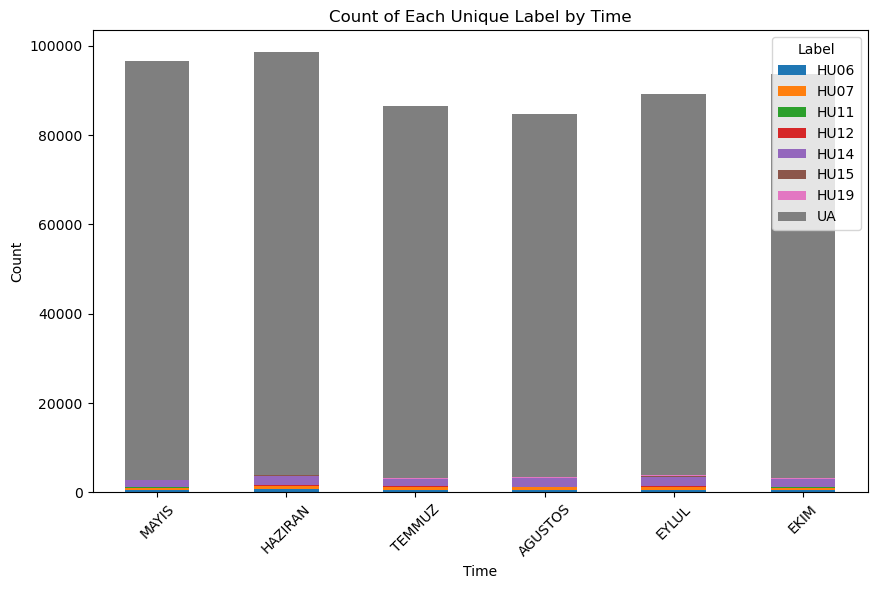

In [34]:
pivot_label_counts.plot(kind='bar', stacked=True, figsize=(10, 6))  
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Count of Each Unique Label by Time')
plt.legend(title='Label')
plt.xticks(rotation=45)  
plt.show()


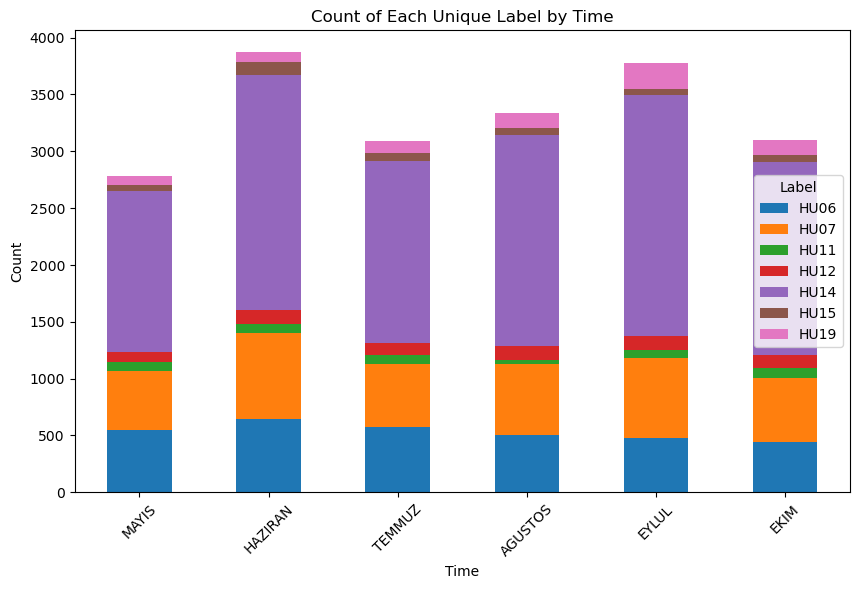

In [35]:
pivot_label_counts_without_ua = pivot_label_counts.drop(columns=["UA"])

pivot_label_counts_without_ua.plot(kind='bar', stacked=True, figsize=(10, 6))  
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Count of Each Unique Label by Time')
plt.legend(title='Label')
plt.xticks(rotation=45)  
plt.show()


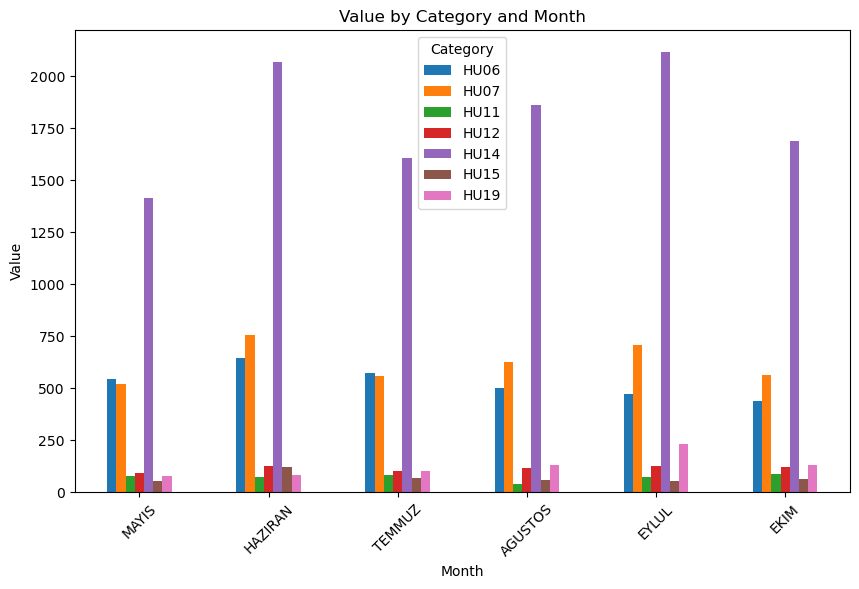

In [36]:
pivot_label_counts_without_ua.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Month')  
plt.ylabel('Value')
plt.title('Value by Category and Month')
plt.xticks(rotation=45)  
plt.legend(title='Category')
plt.show()

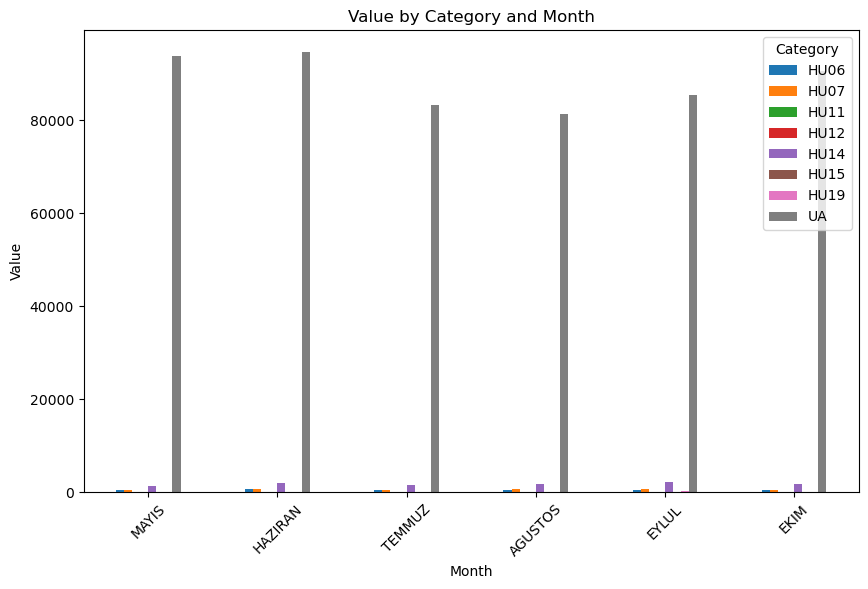

In [37]:
pivot_label_counts.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Month')  
plt.ylabel('Value')
plt.title('Value by Category and Month')
plt.xticks(rotation=45)  
plt.legend(title='Category')
plt.show()

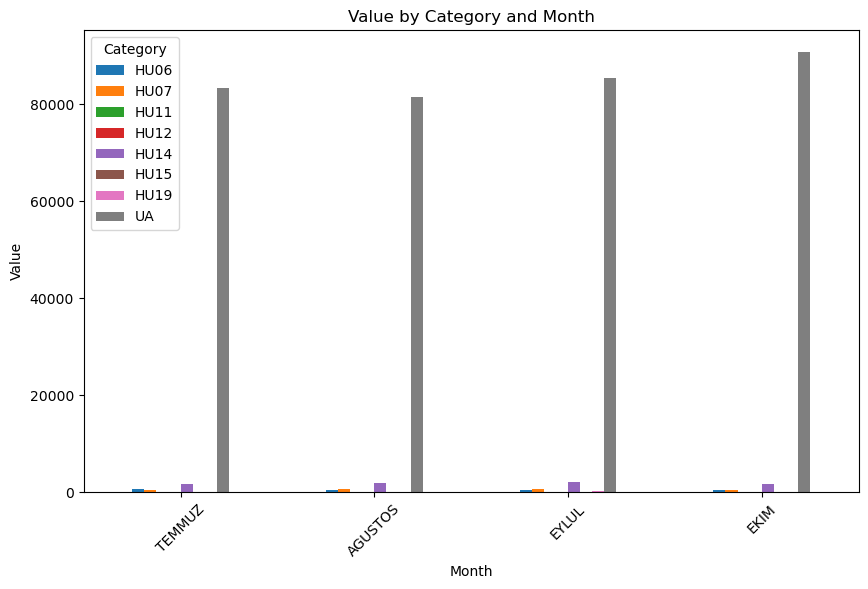

In [38]:
pivoted_label_without_two_month = pivot_label_counts.iloc[2:]

pivoted_label_without_two_month.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Month')  
plt.ylabel('Value')
plt.title('Value by Category and Month')
plt.xticks(rotation=45)  
plt.legend(title='Category')
plt.show()

In [39]:
columns_to_check = [col for col in train_data.columns if col not in ['FLAG']]
nan_mask_per_row = train_data[columns_to_check].isnull().any(axis=1)
nan_counts_per_flag = train_data[nan_mask_per_row].groupby('FLAG').size()
filtered_data = train_data[nan_mask_per_row]
print(nan_counts_per_flag)
filtered_data

FLAG
AGUSTOS    84715
EKIM       93704
EYLUL      89143
HAZIRAN    98449
MAYIS      96563
TEMMUZ     86428
dtype: int64


,MUSTERI_ID,LABEL,FLAG,PP_CINSIYET,PP_YAS,PP_MESLEK,PP_MUSTERI_SEGMENTI,PP_UYRUK,IL,SORU_YATIRIM_KARAKTERI_CVP,...,AVG_VADE_TUTAR,VADE_ODEME_RATIO,ODEME_TUTAR_STD,AVG_KATKI_MIKTARI_SON_AY,AVG_KATKI_MIKTARI_SON_CEYREK,AVG_KATKI_MIKTARI_SON_SENE,KATKI_MIKTARI_GROWTH_RATE_AY_CEYREK,KATKI_MIKTARI_GROWTH_RATE_CEYREK_SENE,ROI,ANNUALIZED_RETURN
2,6af95ba9ebe2362a0b31b4443fb2405b11d588780c01ad...,HU19,HAZIRAN,2,1,Muhasebe,104,1,5,Yetkin,...,856.42,1.00,278.58,NaN,NaN,NaN,NaN,NaN,70.02,0.10
3,fe33e7873368d603d2a49a982619e8d61a964d7a0ef68e...,UA,MAYIS,2,2,Diğer,106,1,7,NaN,...,395.33,NaN,0.00,NaN,NaN,NaN,NaN,NaN,279.21,0.15
4,aae8411e2c335e94922290314abe1fcc81044e8071e1c8...,UA,EYLUL,2,1,İşçi,103,1,7,NaN,...,388.67,3.39,207.59,NaN,NaN,NaN,NaN,NaN,83.53,0.08
7,20e4006651b151e18068b8a9c9233bf5e61c06a98b3db7...,HU07,HAZIRAN,2,1,Diğer,105,1,7,NaN,...,326.50,1.00,108.14,NaN,NaN,NaN,NaN,NaN,227.61,0.14
11,9327b4497439d768c9dcc33f8d41a3d0968ded2660b868...,HU14,EKIM,1,1,İşyeri Sahibi/Ortağı,103,1,5,NaN,...,390.50,1.00,91.36,NaN,NaN,NaN,NaN,NaN,26.34,0.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852707,e92098543d5bda159cc7f02295350406404e25a98e12fa...,UA,EYLUL,2,0,Öğrenci,106,1,1,NaN,...,27.83,1.00,96.42,NaN,NaN,NaN,NaN,NaN,1.06,0.13
852708,31a13b30a5f5fb6200989cd39be47ef13fdf100e3cb5ac...,HU14,EYLUL,1,1,Tacir ve Esnaf,102,1,5,NaN,...,583.67,1.11,224.88,NaN,NaN,NaN,NaN,NaN,114.20,0.29
852709,a3ba51ef14f964225d5b4d67f5f7ed67cfa56dc1e309b9...,UA,EYLUL,1,1,İşçi,104,1,7,NaN,...,775.50,1.00,396.26,NaN,NaN,NaN,NaN,NaN,194.21,0.12
852713,d8137ce2e4cee7d0599e9f1ab95e17478d70a47f311496...,UA,HAZIRAN,1,1,Mühendis,104,1,7,NaN,...,852.92,1.00,546.66,NaN,NaN,NaN,NaN,NaN,33.97,0.17


In [40]:
train_data = drop_columns_from_df(train_data, drop_columns)
test_data = drop_columns_from_df(test_data, drop_columns)

Data Pre-Processing

In [41]:
train_statistical_dict = {}

In [42]:
def convert_numeric_fill_median(data, train=True):
    data["SORU_GELIR_CVP"] = pd.to_numeric(data["SORU_GELIR_CVP"], errors="coerce")

    if train:
        mean_value = data["SORU_GELIR_CVP"].mean()
        data["SORU_GELIR_CVP"].fillna(mean_value,inplace=True)
        train_statistical_dict["SORU_GELIR_CVP"] = mean_value

        print(data["SORU_GELIR_CVP"].head(10))
    else:
        data["SORU_GELIR_CVP"].fillna(train_statistical_dict["SORU_GELIR_CVP"], inplace=True)

In [43]:
# "SORU_GELIR_CVP" column is an object tpe column but it should be float
convert_numeric_fill_median(train_data)
convert_numeric_fill_median(test_data, train=False)

2     36972.822904
3         1.000000
4      1500.000000
7         0.000000
11    10000.000000
12     5000.000000
13    36972.822904
14    10000.000000
15    36972.822904
17        0.000000
Name: SORU_GELIR_CVP, dtype: float64


In [44]:
# my_report = sv.analyze(train_data)
# my_report.show_notebook()

In [45]:
# Fill Nan-Categorical columns with the median of their own column
def fill_numeric_with_median(data, train=True):
    nan_categorical_columns = data.select_dtypes(exclude=['category', 'object']).columns

    if train:
        columns_with_nans = data.columns[data.isna().any()]

        nan_categorical_with_nans = [col for col in nan_categorical_columns if col in columns_with_nans]
        print(nan_categorical_with_nans)

        for col in nan_categorical_columns:
            median_value = data[col].median()
            data[col] = data[col].fillna(median_value)
            train_statistical_dict[col] = median_value
    
    else:
        for col in nan_categorical_columns:
            data[col] = data[col].fillna(train_statistical_dict[col])

In [46]:
# fill_numeric_with_median(train_data)
# fill_numeric_with_median(test_data, train=False)

# print(count_nans(test_data))
# count_nans(train_data)

In [47]:
labels = train_data["LABEL"].value_counts()
labels

UA      529399
HU14     10754
HU07      3728
HU06      3178
HU19       759
HU12       676
HU11       439
HU15       415
Name: LABEL, dtype: int64

In [48]:
train_data["LABEL"].isna().sum()

0

In [49]:
def get_categorical_columns(data):
    categorical_columns = data.select_dtypes(include=["category", "object"]).columns

    columns_to_remove = ["MUSTERI_ID", "LABEL"]
    categorical_columns_updated = [col for col in categorical_columns if col not in columns_to_remove]

    return categorical_columns_updated

In [50]:
categorical_columns = get_categorical_columns(train_data)

for i in ["IL","PP_CINSIYET","PP_YAS","PP_MUSTERI_SEGMENTI","PP_UYRUK",'BU01', 'BU02', 'BU03',
       'BU04', 'BU05', 'BU06', 'BU07', 'BU08', 'BU09', 'BU10', 'BU11', 'BU12',
       'BU13', 'BU14', 'BU15', 'BU16', 'BU17', 'BU18', 'BU19', 'BU20', 'BU21',
       'BU22', 'BU23', 'BU24', 'HU01', 'HU02', 'HU03', 'HU04', 'HU05', 'HU06',
       'HU07', 'HU10', 'HU11', 'HU12', 'HU13', 'HU14', 'HU15', 'HU16', 'HU17',
       'HU18', 'HU19']:
    categorical_columns.append(i)

In [51]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 549348 entries, 2 to 852716
Columns: 106 entries, MUSTERI_ID to ANNUALIZED_RETURN
dtypes: float64(50), int64(51), object(5)
memory usage: 448.5+ MB


In [52]:
def calculate_class_weights(data_y):
    freq = data_y.value_counts()
    inv_freq = 1 / freq
    weights = inv_freq / inv_freq.sum()
    class_weights = {label: weight for label, weight in weights.items()}
    sorted_keys = np.sort(list(class_weights.keys()))
    print(sorted_keys)
    sorted_weights_by_keys = [class_weights[key] for key in sorted_keys]

    return sorted_weights_by_keys

In [53]:
custom_weights = np.array([0.0385, 0.0328, 0.2791, 0.1812, 0.0113, 0.2952, 0.1614, 0.0001])

In [54]:
categorical_columns

['SORU_YATIRIM_KARAKTERI_CVP',
 'SORU_MEDENI_HAL_CVP',
 'SORU_EGITIM_CVP',
 'IL',
 'PP_CINSIYET',
 'PP_YAS',
 'PP_MUSTERI_SEGMENTI',
 'PP_UYRUK',
 'BU01',
 'BU02',
 'BU03',
 'BU04',
 'BU05',
 'BU06',
 'BU07',
 'BU08',
 'BU09',
 'BU10',
 'BU11',
 'BU12',
 'BU13',
 'BU14',
 'BU15',
 'BU16',
 'BU17',
 'BU18',
 'BU19',
 'BU20',
 'BU21',
 'BU22',
 'BU23',
 'BU24',
 'HU01',
 'HU02',
 'HU03',
 'HU04',
 'HU05',
 'HU06',
 'HU07',
 'HU10',
 'HU11',
 'HU12',
 'HU13',
 'HU14',
 'HU15',
 'HU16',
 'HU17',
 'HU18',
 'HU19']

In [55]:
def outlier_handle(df):
    indexies = df.loc[(df['SORU_GELIR_CVP'] > 40000) | (df['SORU_GELIR_CVP'] < 1000),"SORU_GELIR_CVP"].index
    df.loc[(df['SORU_GELIR_CVP'] > 40000) | (df['SORU_GELIR_CVP'] < 1000),"SORU_GELIR_CVP"] = np.nan
    return df

train_data = outlier_handle(train_data)
test_data = outlier_handle(test_data)

In [56]:

num_cols = train_data.drop(['SORU_YATIRIM_KARAKTERI_CVP', 'SORU_MEDENI_HAL_CVP','SORU_EGITIM_CVP'],axis=1).select_dtypes(include=['int64', 'float64']).columns
#selected_cols = df.drop(['MUSTERI_ID','LABEL','is_train'],axis=1).columns

imputer = CatBoostImputer(verbose=False)

train_data[num_cols] = imputer.fit_transform(train_data[num_cols])
test_data[num_cols] = imputer.fit_transform(test_data[num_cols])
#for i in num_cols:
#    df[i] = df[i].fillna(df[i].mean())

In [57]:
train_X = train_data.drop(columns=["LABEL", "MUSTERI_ID"])
train_Y = train_data["LABEL"]

# test_data_X.fillna('missing', inplace=True)
for col in categorical_columns:
    train_X[col] = train_X[col].astype(str)

In [58]:
class_labels = np.sort(np.unique(train_Y))
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_Y)

class_weights = {label: weight for label, weight in zip(class_labels, weights)}

print(class_weights)

{'HU06': 21.607457520453114, 'HU07': 18.419662017167383, 'HU11': 156.42027334851937, 'HU12': 101.58062130177515, 'HU14': 6.385391482239167, 'HU15': 165.46626506024097, 'HU19': 90.47233201581028, 'UA': 0.1297102941259806}


In [59]:
class_labels

array(['HU06', 'HU07', 'HU11', 'HU12', 'HU14', 'HU15', 'HU19', 'UA'],
      dtype=object)

In [60]:
sorted_weights_by_keys = calculate_class_weights(train_Y)
sorted_weights_by_keys

['HU06' 'HU07' 'HU11' 'HU12' 'HU14' 'HU15' 'HU19' 'UA']


[0.03855158342855385,
 0.0328639839420451,
 0.2790818499679821,
 0.18123806528985817,
 0.01139268478109951,
 0.2952215232191425,
 0.1614188829195575,
 0.00023142645176123139]

In [61]:
def objective(trial):
    param = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50),
        "max_leaves": trial.suggest_int("max_leaves", 16, 64),
        "depth": trial.suggest_int("depth", 4, 13),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 10),  # Using loguniform for a wider range
        "model_size_reg": trial.suggest_float("model_size_reg", 0.0, 10.0),
        "random_strength": trial.suggest_float("random_strength", 0.1, 1),
        # "leaf_estimation_iterations": trial.suggest_int("leaf_estimation_iterations", 1, 100),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli"]),
    }

    if param['bootstrap_type'] == 'Bayesian':
        param['bagging_temperature'] = trial.suggest_float("bagging_temperature", 0, 1)


    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    weighted_total_f1 = []
    scores = []
    for fold, (train_index, test_index) in enumerate(skf.split(train_X, train_Y)):
        X_train, X_validate = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_validate = train_Y.iloc[train_index], train_Y.iloc[test_index]

        train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_columns)
        validate_pool = Pool(data=X_validate, label=y_validate, cat_features=categorical_columns)

        validate_class_weights = calculate_class_weights(y_train)

        model = CatBoostClassifier(**param, task_type="GPU", devices="0", grow_policy='Lossguide', auto_class_weights='SqrtBalanced', loss_function="MultiClass", allow_writing_files=False)
        model.fit(train_pool, eval_set=validate_pool, verbose=True)

        preds = model.predict(X_validate)  
                
        print(model.classes_)

        f1_scores = f1_score(y_validate, preds, average=None, labels=model.classes_)
        f1_pondere = np.multiply(validate_class_weights, f1_scores) 

        weighted_f1= f1_pondere.sum()
        weighted_total_f1.append(weighted_f1)
        print("weighted f1 skor: ",weighted_f1)

        # weighted_f1 = np.average(f1_scores, weights=custom_weights)
        scores.append(f1_scores)

        trial.report(weighted_f1, fold)
        if trial.should_prune():
            raise optuna.TrialPruned()

    # Return the average score across all folds
    return np.mean(weighted_total_f1)


In [62]:
study_name = "CatBoost"
storage_url = "sqlite:///db.sqlite3"

storage = optuna.storages.RDBStorage(url=storage_url)

# Check if the study exists
study_names = [study.study_name for study in optuna.study.get_all_study_summaries(storage=storage)]
if study_name in study_names:
    # Delete the study if it exists
    print(f"Deleting study '{study_name}'")
    optuna.delete_study(study_name=study_name, storage=storage_url)
else:
    print(f"Study '{study_name}' does not exist in the storage.")
    
study = optuna.create_study(direction='maximize', 
                            storage=storage_url, 
                            sampler=TPESampler(),
                            pruner=optuna.pruners.SuccessiveHalvingPruner(
                            min_resource=2,  # Minimum amount of resource allocated to a trial
                            reduction_factor=3,  # Reduction factor for pruning
                            min_early_stopping_rate=1 # Minimum early-stopping rate
                            ),
                            study_name=study_name,
                            load_if_exists=False)

pbar = tqdm(total=20, desc='Optimizing', unit='trial')

def callback(study, trial):
    # Update the progress bar
    pbar.update(1)
    pbar.set_postfix_str(f"Best Value: {study.best_value:.4f}")

study.optimize(objective, n_trials=20, callbacks=[callback])
pbar.close()

# Best hyperparameters
print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value:', trial.value)
print('Params:')
for key, value in trial.params.items():
    print(f'{key}: {value}')

[I 2024-03-27 02:20:15,342] A new study created in RDB with name: CatBoost


Deleting study 'CatBoost'


Optimizing:   0%|          | 0/20 [00:00<?, ?trial/s]

['HU06' 'HU07' 'HU11' 'HU12' 'HU14' 'HU15' 'HU19' 'UA']
0:	learn: 1.1066349	test: 1.1076933	best: 1.1076933 (0)	total: 98.7ms	remaining: 48.5s
1:	learn: 0.9713870	test: 0.9758866	best: 0.9758866 (1)	total: 193ms	remaining: 47.3s
2:	learn: 0.8973675	test: 0.9061428	best: 0.9061428 (2)	total: 279ms	remaining: 45.5s
3:	learn: 0.8473548	test: 0.8624555	best: 0.8624555 (3)	total: 363ms	remaining: 44.3s
4:	learn: 0.8104531	test: 0.8290182	best: 0.8290182 (4)	total: 446ms	remaining: 43.4s
5:	learn: 0.7742077	test: 0.7992065	best: 0.7992065 (5)	total: 529ms	remaining: 42.8s
6:	learn: 0.7547664	test: 0.7845442	best: 0.7845442 (6)	total: 600ms	remaining: 41.6s
7:	learn: 0.7365453	test: 0.7741780	best: 0.7741780 (7)	total: 681ms	remaining: 41.2s
8:	learn: 0.7259085	test: 0.7662806	best: 0.7662806 (8)	total: 748ms	remaining: 40.1s
9:	learn: 0.7123032	test: 0.7581803	best: 0.7581803 (9)	total: 828ms	remaining: 39.9s
10:	learn: 0.7041965	test: 0.7537457	best: 0.7537457 (10)	total: 895ms	remaining: 3

[I 2024-03-27 02:22:39,284] Trial 0 finished with value: 0.2350650700488638 and parameters: {'iterations': 492, 'learning_rate': 0.3311378953149558, 'min_data_in_leaf': 7, 'max_leaves': 61, 'depth': 6, 'l2_leaf_reg': 3.1463646744201, 'model_size_reg': 7.17654771645953, 'random_strength': 0.7130513564140963, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.2350650700488638.


['HU06' 'HU07' 'HU11' 'HU12' 'HU14' 'HU15' 'HU19' 'UA']
0:	learn: 1.6795762	test: 1.6794424	best: 1.6794424 (0)	total: 102ms	remaining: 45.6s
1:	learn: 1.4808000	test: 1.4807567	best: 1.4807567 (1)	total: 196ms	remaining: 44s
2:	learn: 1.3481245	test: 1.3483661	best: 1.3483661 (2)	total: 286ms	remaining: 42.6s
3:	learn: 1.2498329	test: 1.2507598	best: 1.2507598 (3)	total: 377ms	remaining: 42s
4:	learn: 1.1742636	test: 1.1761301	best: 1.1761301 (4)	total: 460ms	remaining: 41s
5:	learn: 1.1130448	test: 1.1156859	best: 1.1156859 (5)	total: 543ms	remaining: 40.2s
6:	learn: 1.0626667	test: 1.0658683	best: 1.0658683 (6)	total: 627ms	remaining: 39.7s
7:	learn: 1.0209644	test: 1.0251141	best: 1.0251141 (7)	total: 711ms	remaining: 39.3s
8:	learn: 0.9839102	test: 0.9896444	best: 0.9896444 (8)	total: 794ms	remaining: 38.9s
9:	learn: 0.9526103	test: 0.9591649	best: 0.9591649 (9)	total: 879ms	remaining: 38.7s
10:	learn: 0.9255789	test: 0.9335708	best: 0.9335708 (10)	total: 966ms	remaining: 38.6s
11

[I 2024-03-27 02:24:50,799] Trial 1 finished with value: 0.263845781258191 and parameters: {'iterations': 450, 'learning_rate': 0.10641105200281213, 'min_data_in_leaf': 50, 'max_leaves': 45, 'depth': 8, 'l2_leaf_reg': 7.450082171909286, 'model_size_reg': 8.09363857100732, 'random_strength': 0.41209141596666465, 'bootstrap_type': 'Bernoulli'}. Best is trial 1 with value: 0.263845781258191.


['HU06' 'HU07' 'HU11' 'HU12' 'HU14' 'HU15' 'HU19' 'UA']
0:	learn: 1.2789480	test: 1.2769304	best: 1.2769304 (0)	total: 86.3ms	remaining: 37.1s
1:	learn: 1.1099334	test: 1.1096959	best: 1.1096959 (1)	total: 167ms	remaining: 35.8s
2:	learn: 1.0070814	test: 1.0090845	best: 1.0090845 (2)	total: 247ms	remaining: 35.2s
3:	learn: 0.9420097	test: 0.9450989	best: 0.9450989 (3)	total: 324ms	remaining: 34.6s
4:	learn: 0.8928014	test: 0.8985880	best: 0.8985880 (4)	total: 407ms	remaining: 34.6s
5:	learn: 0.8536395	test: 0.8618090	best: 0.8618090 (5)	total: 493ms	remaining: 34.9s
6:	learn: 0.8279549	test: 0.8371561	best: 0.8371561 (6)	total: 578ms	remaining: 35s
7:	learn: 0.8041997	test: 0.8153404	best: 0.8153404 (7)	total: 656ms	remaining: 34.7s
8:	learn: 0.7864349	test: 0.7994042	best: 0.7994042 (8)	total: 737ms	remaining: 34.5s
9:	learn: 0.7744199	test: 0.7896421	best: 0.7896421 (9)	total: 811ms	remaining: 34.2s
10:	learn: 0.7600638	test: 0.7775151	best: 0.7775151 (10)	total: 889ms	remaining: 33.

[I 2024-03-27 02:26:53,072] Trial 2 finished with value: 0.2526086945891284 and parameters: {'iterations': 431, 'learning_rate': 0.24682340296534372, 'min_data_in_leaf': 15, 'max_leaves': 28, 'depth': 6, 'l2_leaf_reg': 6.325043130379497, 'model_size_reg': 8.163644201174797, 'random_strength': 0.941458267607261, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6032910578000975}. Best is trial 1 with value: 0.263845781258191.


['HU06' 'HU07' 'HU11' 'HU12' 'HU14' 'HU15' 'HU19' 'UA']
0:	learn: 1.0656968	test: 1.0671860	best: 1.0671860 (0)	total: 94.4ms	remaining: 22.3s
1:	learn: 0.9496747	test: 0.9567588	best: 0.9567588 (1)	total: 177ms	remaining: 20.8s
2:	learn: 0.8696741	test: 0.8815413	best: 0.8815413 (2)	total: 265ms	remaining: 20.7s
3:	learn: 0.8238761	test: 0.8415487	best: 0.8415487 (3)	total: 350ms	remaining: 20.4s
4:	learn: 0.7901260	test: 0.8114117	best: 0.8114117 (4)	total: 432ms	remaining: 20.1s
5:	learn: 0.7655852	test: 0.7935176	best: 0.7935176 (5)	total: 510ms	remaining: 19.6s
6:	learn: 0.7507562	test: 0.7846826	best: 0.7846826 (6)	total: 577ms	remaining: 19s
7:	learn: 0.7342783	test: 0.7713952	best: 0.7713952 (7)	total: 651ms	remaining: 18.6s
8:	learn: 0.7195531	test: 0.7632653	best: 0.7632653 (8)	total: 725ms	remaining: 18.4s
9:	learn: 0.7102624	test: 0.7571896	best: 0.7571896 (9)	total: 804ms	remaining: 18.2s
10:	learn: 0.6982200	test: 0.7495044	best: 0.7495044 (10)	total: 880ms	remaining: 18.

[I 2024-03-27 02:28:17,564] Trial 3 finished with value: 0.24097371971438705 and parameters: {'iterations': 237, 'learning_rate': 0.3505558814370974, 'min_data_in_leaf': 35, 'max_leaves': 44, 'depth': 7, 'l2_leaf_reg': 5.206657228550474, 'model_size_reg': 0.14840157665417908, 'random_strength': 0.3849276421948318, 'bootstrap_type': 'Bernoulli'}. Best is trial 1 with value: 0.263845781258191.


['HU06' 'HU07' 'HU11' 'HU12' 'HU14' 'HU15' 'HU19' 'UA']
0:	learn: 0.9634608	test: 0.9639439	best: 0.9639439 (0)	total: 79.4ms	remaining: 19.6s
1:	learn: 0.8791917	test: 0.8839602	best: 0.8839602 (1)	total: 158ms	remaining: 19.5s
2:	learn: 0.8230421	test: 0.8334116	best: 0.8334116 (2)	total: 238ms	remaining: 19.4s
3:	learn: 0.7845103	test: 0.7991089	best: 0.7991089 (3)	total: 316ms	remaining: 19.3s
4:	learn: 0.7586350	test: 0.7791246	best: 0.7791246 (4)	total: 395ms	remaining: 19.2s
5:	learn: 0.7418134	test: 0.7690349	best: 0.7690349 (5)	total: 471ms	remaining: 19s
6:	learn: 0.7270817	test: 0.7584621	best: 0.7584621 (6)	total: 549ms	remaining: 18.9s
7:	learn: 0.7151263	test: 0.7540080	best: 0.7540080 (7)	total: 619ms	remaining: 18.6s
8:	learn: 0.7057593	test: 0.7506465	best: 0.7506465 (8)	total: 692ms	remaining: 18.4s
9:	learn: 0.6977960	test: 0.7498177	best: 0.7498177 (9)	total: 752ms	remaining: 17.9s
10:	learn: 0.6915604	test: 0.7481705	best: 0.7481705 (10)	total: 818ms	remaining: 17.

[I 2024-03-27 02:29:39,336] Trial 4 finished with value: 0.2152796326822768 and parameters: {'iterations': 248, 'learning_rate': 0.44236781857947416, 'min_data_in_leaf': 28, 'max_leaves': 32, 'depth': 13, 'l2_leaf_reg': 5.782383131060213, 'model_size_reg': 0.7755713596883496, 'random_strength': 0.49979505257748746, 'bootstrap_type': 'Bernoulli'}. Best is trial 1 with value: 0.263845781258191.


['HU06' 'HU07' 'HU11' 'HU12' 'HU14' 'HU15' 'HU19' 'UA']
0:	learn: 1.5835379	test: 1.5836909	best: 1.5836909 (0)	total: 126ms	remaining: 17.2s
1:	learn: 1.3765791	test: 1.3767402	best: 1.3767402 (1)	total: 226ms	remaining: 15.4s
2:	learn: 1.2445682	test: 1.2453123	best: 1.2453123 (2)	total: 319ms	remaining: 14.3s
3:	learn: 1.1505043	test: 1.1520458	best: 1.1520458 (3)	total: 405ms	remaining: 13.6s
4:	learn: 1.0783479	test: 1.0813257	best: 1.0813257 (4)	total: 493ms	remaining: 13.1s
5:	learn: 1.0222251	test: 1.0264081	best: 1.0264081 (5)	total: 578ms	remaining: 12.7s
6:	learn: 0.9768509	test: 0.9823099	best: 0.9823099 (6)	total: 666ms	remaining: 12.5s
7:	learn: 0.9386559	test: 0.9455470	best: 0.9455470 (7)	total: 754ms	remaining: 12.3s
8:	learn: 0.9078295	test: 0.9163027	best: 0.9163027 (8)	total: 837ms	remaining: 12s
9:	learn: 0.8810925	test: 0.8914605	best: 0.8914605 (9)	total: 922ms	remaining: 11.8s
10:	learn: 0.8586110	test: 0.8706918	best: 0.8706918 (10)	total: 1.01s	remaining: 11.6

[I 2024-03-27 02:30:45,711] Trial 5 finished with value: 0.2605885998737339 and parameters: {'iterations': 138, 'learning_rate': 0.13471619756473263, 'min_data_in_leaf': 24, 'max_leaves': 41, 'depth': 10, 'l2_leaf_reg': 6.597777931405024, 'model_size_reg': 7.744765774984172, 'random_strength': 0.8966240973850876, 'bootstrap_type': 'Bernoulli'}. Best is trial 1 with value: 0.263845781258191.


['HU06' 'HU07' 'HU11' 'HU12' 'HU14' 'HU15' 'HU19' 'UA']
0:	learn: 1.3844659	test: 1.3833342	best: 1.3833342 (0)	total: 88.3ms	remaining: 11.5s
1:	learn: 1.1949132	test: 1.1945625	best: 1.1945625 (1)	total: 179ms	remaining: 11.5s
2:	learn: 1.0808432	test: 1.0818653	best: 1.0818653 (2)	total: 275ms	remaining: 11.7s
3:	learn: 1.0006282	test: 1.0026612	best: 1.0026612 (3)	total: 368ms	remaining: 11.7s
4:	learn: 0.9425972	test: 0.9465392	best: 0.9465392 (4)	total: 454ms	remaining: 11.4s
5:	learn: 0.8975980	test: 0.9038055	best: 0.9038055 (5)	total: 548ms	remaining: 11.4s
6:	learn: 0.8638083	test: 0.8726350	best: 0.8726350 (6)	total: 647ms	remaining: 11.5s
7:	learn: 0.8326533	test: 0.8457516	best: 0.8457516 (7)	total: 737ms	remaining: 11.3s
8:	learn: 0.8102480	test: 0.8261304	best: 0.8261304 (8)	total: 826ms	remaining: 11.2s
9:	learn: 0.7933011	test: 0.8124459	best: 0.8124459 (9)	total: 914ms	remaining: 11.1s
10:	learn: 0.7770302	test: 0.7981393	best: 0.7981393 (10)	total: 1s	remaining: 11s


[I 2024-03-27 02:31:52,246] Trial 6 finished with value: 0.2529115447526858 and parameters: {'iterations': 131, 'learning_rate': 0.20167942613031525, 'min_data_in_leaf': 14, 'max_leaves': 36, 'depth': 8, 'l2_leaf_reg': 7.0410637087138035, 'model_size_reg': 9.731109640686697, 'random_strength': 0.194405285405997, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.48004077875596973}. Best is trial 1 with value: 0.263845781258191.


['HU06' 'HU07' 'HU11' 'HU12' 'HU14' 'HU15' 'HU19' 'UA']
0:	learn: 1.0755392	test: 1.0717008	best: 1.0717008 (0)	total: 73ms	remaining: 23.1s
1:	learn: 0.9562710	test: 0.9542060	best: 0.9542060 (1)	total: 142ms	remaining: 22.5s
2:	learn: 0.8895781	test: 0.8916410	best: 0.8916410 (2)	total: 212ms	remaining: 22.2s
3:	learn: 0.8486412	test: 0.8529274	best: 0.8529274 (3)	total: 279ms	remaining: 21.9s
4:	learn: 0.8223425	test: 0.8295938	best: 0.8295938 (4)	total: 340ms	remaining: 21.3s
5:	learn: 0.8021037	test: 0.8137654	best: 0.8137654 (5)	total: 397ms	remaining: 20.7s
6:	learn: 0.7850046	test: 0.7989252	best: 0.7989252 (6)	total: 456ms	remaining: 20.2s
7:	learn: 0.7699262	test: 0.7910239	best: 0.7910239 (7)	total: 516ms	remaining: 20s
8:	learn: 0.7579068	test: 0.7813757	best: 0.7813757 (8)	total: 575ms	remaining: 19.7s
9:	learn: 0.7434352	test: 0.7685722	best: 0.7685722 (9)	total: 635ms	remaining: 19.6s
10:	learn: 0.7350866	test: 0.7633178	best: 0.7633178 (10)	total: 695ms	remaining: 19.4s

[I 2024-03-27 02:33:19,808] Trial 7 finished with value: 0.2357478435053367 and parameters: {'iterations': 318, 'learning_rate': 0.36733413811601084, 'min_data_in_leaf': 18, 'max_leaves': 23, 'depth': 5, 'l2_leaf_reg': 6.474874182820443, 'model_size_reg': 4.7726930022075, 'random_strength': 0.7379223800505718, 'bootstrap_type': 'Bernoulli'}. Best is trial 1 with value: 0.263845781258191.


['HU06' 'HU07' 'HU11' 'HU12' 'HU14' 'HU15' 'HU19' 'UA']
0:	learn: 1.0830165	test: 1.0829186	best: 1.0829186 (0)	total: 88.2ms	remaining: 29.7s
1:	learn: 0.9595975	test: 0.9637613	best: 0.9637613 (1)	total: 177ms	remaining: 29.8s
2:	learn: 0.8873333	test: 0.8966634	best: 0.8966634 (2)	total: 267ms	remaining: 29.8s
3:	learn: 0.8415186	test: 0.8559731	best: 0.8559731 (3)	total: 353ms	remaining: 29.5s
4:	learn: 0.8109708	test: 0.8293858	best: 0.8293858 (4)	total: 439ms	remaining: 29.2s
5:	learn: 0.7781448	test: 0.8032008	best: 0.8032008 (5)	total: 532ms	remaining: 29.5s
6:	learn: 0.7596538	test: 0.7882602	best: 0.7882602 (6)	total: 615ms	remaining: 29.1s
7:	learn: 0.7456850	test: 0.7790501	best: 0.7790501 (7)	total: 697ms	remaining: 28.8s
8:	learn: 0.7346522	test: 0.7705691	best: 0.7705691 (8)	total: 779ms	remaining: 28.5s
9:	learn: 0.7237451	test: 0.7647269	best: 0.7647269 (9)	total: 865ms	remaining: 28.4s
10:	learn: 0.7180508	test: 0.7631099	best: 0.7631099 (10)	total: 936ms	remaining: 2

[I 2024-03-27 02:35:11,540] Trial 8 finished with value: 0.18933842671527654 and parameters: {'iterations': 338, 'learning_rate': 0.34008902663509627, 'min_data_in_leaf': 7, 'max_leaves': 36, 'depth': 7, 'l2_leaf_reg': 0.16396352380098514, 'model_size_reg': 2.9742720901601203, 'random_strength': 0.3898594549443837, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.9276169355479447}. Best is trial 1 with value: 0.263845781258191.


['HU06' 'HU07' 'HU11' 'HU12' 'HU14' 'HU15' 'HU19' 'UA']
0:	learn: 1.3401437	test: 1.3417443	best: 1.3417443 (0)	total: 140ms	remaining: 23.1s
1:	learn: 1.1514330	test: 1.1555426	best: 1.1555426 (1)	total: 273ms	remaining: 22.4s
2:	learn: 1.0375880	test: 1.0448187	best: 1.0448187 (2)	total: 396ms	remaining: 21.5s
3:	learn: 0.9613347	test: 0.9715491	best: 0.9715491 (3)	total: 513ms	remaining: 20.8s
4:	learn: 0.9056786	test: 0.9201030	best: 0.9201030 (4)	total: 629ms	remaining: 20.2s
5:	learn: 0.8616287	test: 0.8806908	best: 0.8806908 (5)	total: 749ms	remaining: 20s
6:	learn: 0.8274283	test: 0.8513843	best: 0.8513843 (6)	total: 868ms	remaining: 19.7s
7:	learn: 0.7993182	test: 0.8280929	best: 0.8280929 (7)	total: 984ms	remaining: 19.4s
8:	learn: 0.7750362	test: 0.8087807	best: 0.8087807 (8)	total: 1.1s	remaining: 19.3s
9:	learn: 0.7576347	test: 0.7963741	best: 0.7963741 (9)	total: 1.22s	remaining: 19s
10:	learn: 0.7420220	test: 0.7848146	best: 0.7848146 (10)	total: 1.33s	remaining: 18.8s
1

[I 2024-03-27 02:36:36,952] Trial 9 finished with value: 0.25523458697392215 and parameters: {'iterations': 166, 'learning_rate': 0.21110645807319625, 'min_data_in_leaf': 21, 'max_leaves': 64, 'depth': 12, 'l2_leaf_reg': 5.1388474703654525, 'model_size_reg': 6.552400586104237, 'random_strength': 0.2927892935400078, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.8488138740128974}. Best is trial 1 with value: 0.263845781258191.


['HU06' 'HU07' 'HU11' 'HU12' 'HU14' 'HU15' 'HU19' 'UA']
0:	learn: 2.0198090	test: 2.0198131	best: 2.0198131 (0)	total: 92.8ms	remaining: 37.1s
1:	learn: 1.9657091	test: 1.9656648	best: 1.9656648 (1)	total: 187ms	remaining: 37.3s
2:	learn: 1.9163219	test: 1.9162544	best: 1.9162544 (2)	total: 280ms	remaining: 37.2s
3:	learn: 1.8710367	test: 1.8709861	best: 1.8709861 (3)	total: 375ms	remaining: 37.3s
4:	learn: 1.8290621	test: 1.8289778	best: 1.8289778 (4)	total: 468ms	remaining: 37.1s
5:	learn: 1.7901608	test: 1.7900545	best: 1.7900545 (5)	total: 562ms	remaining: 37s
6:	learn: 1.7537217	test: 1.7536218	best: 1.7536218 (6)	total: 656ms	remaining: 36.9s
7:	learn: 1.7196639	test: 1.7195813	best: 1.7195813 (7)	total: 753ms	remaining: 37s
8:	learn: 1.6875660	test: 1.6875244	best: 1.6875244 (8)	total: 848ms	remaining: 37s
9:	learn: 1.6573575	test: 1.6573310	best: 1.6573310 (9)	total: 943ms	remaining: 36.9s
10:	learn: 1.6288105	test: 1.6288803	best: 1.6288803 (10)	total: 1.04s	remaining: 36.8s
1

[I 2024-03-27 02:39:01,982] Trial 10 finished with value: 0.2488493509261873 and parameters: {'iterations': 401, 'learning_rate': 0.01488119764385587, 'min_data_in_leaf': 50, 'max_leaves': 52, 'depth': 10, 'l2_leaf_reg': 9.971996495509108, 'model_size_reg': 4.52211328851565, 'random_strength': 0.12767655375273956, 'bootstrap_type': 'Bernoulli'}. Best is trial 1 with value: 0.263845781258191.


['HU06' 'HU07' 'HU11' 'HU12' 'HU14' 'HU15' 'HU19' 'UA']
0:	learn: 1.7512397	test: 1.7512810	best: 1.7512810 (0)	total: 108ms	remaining: 10.9s
1:	learn: 1.5637630	test: 1.5636967	best: 1.5636967 (1)	total: 210ms	remaining: 10.5s
2:	learn: 1.4322851	test: 1.4326183	best: 1.4326183 (2)	total: 308ms	remaining: 10.2s
3:	learn: 1.3337240	test: 1.3343967	best: 1.3343967 (3)	total: 401ms	remaining: 9.82s
4:	learn: 1.2551208	test: 1.2565313	best: 1.2565313 (4)	total: 490ms	remaining: 9.51s
5:	learn: 1.1910385	test: 1.1929833	best: 1.1929833 (5)	total: 578ms	remaining: 9.25s
6:	learn: 1.1372332	test: 1.1399755	best: 1.1399755 (6)	total: 670ms	remaining: 9.09s
7:	learn: 1.0911044	test: 1.0946642	best: 1.0946642 (7)	total: 759ms	remaining: 8.92s
8:	learn: 1.0514492	test: 1.0557034	best: 1.0557034 (8)	total: 850ms	remaining: 8.78s
9:	learn: 1.0173885	test: 1.0225765	best: 1.0225765 (9)	total: 941ms	remaining: 8.65s
10:	learn: 0.9880114	test: 0.9939655	best: 0.9939655 (10)	total: 1.03s	remaining: 8.

[I 2024-03-27 02:40:03,871] Trial 11 finished with value: 0.2509624892260927 and parameters: {'iterations': 102, 'learning_rate': 0.08572910790841104, 'min_data_in_leaf': 42, 'max_leaves': 46, 'depth': 10, 'l2_leaf_reg': 8.663636014821465, 'model_size_reg': 9.81068500637812, 'random_strength': 0.6499993763720187, 'bootstrap_type': 'Bernoulli'}. Best is trial 1 with value: 0.263845781258191.


['HU06' 'HU07' 'HU11' 'HU12' 'HU14' 'HU15' 'HU19' 'UA']
0:	learn: 1.6254437	test: 1.6256039	best: 1.6256039 (0)	total: 95.2ms	remaining: 22.8s
1:	learn: 1.4190333	test: 1.4199495	best: 1.4199495 (1)	total: 198ms	remaining: 23.7s
2:	learn: 1.2846153	test: 1.2862420	best: 1.2862420 (2)	total: 293ms	remaining: 23.2s
3:	learn: 1.1871876	test: 1.1898486	best: 1.1898486 (3)	total: 385ms	remaining: 22.8s
4:	learn: 1.1125602	test: 1.1167145	best: 1.1167145 (4)	total: 479ms	remaining: 22.6s
5:	learn: 1.0535926	test: 1.0594200	best: 1.0594200 (5)	total: 572ms	remaining: 22.4s
6:	learn: 1.0048242	test: 1.0118097	best: 1.0118097 (6)	total: 669ms	remaining: 22.4s
7:	learn: 0.9652094	test: 0.9736323	best: 0.9736323 (7)	total: 764ms	remaining: 22.3s
8:	learn: 0.9309071	test: 0.9412316	best: 0.9412316 (8)	total: 859ms	remaining: 22.1s
9:	learn: 0.9012884	test: 0.9137260	best: 0.9137260 (9)	total: 956ms	remaining: 22.1s
10:	learn: 0.8773738	test: 0.8917772	best: 0.8917772 (10)	total: 1.04s	remaining: 2

[I 2024-03-27 02:41:37,703] Trial 12 finished with value: 0.2556401983385841 and parameters: {'iterations': 241, 'learning_rate': 0.12103205357459983, 'min_data_in_leaf': 31, 'max_leaves': 53, 'depth': 10, 'l2_leaf_reg': 7.853432647338279, 'model_size_reg': 7.355381113797102, 'random_strength': 0.9451783751254077, 'bootstrap_type': 'Bernoulli'}. Best is trial 1 with value: 0.263845781258191.


['HU06' 'HU07' 'HU11' 'HU12' 'HU14' 'HU15' 'HU19' 'UA']
0:	learn: 1.6012796	test: 1.6013735	best: 1.6013735 (0)	total: 99.9ms	remaining: 38.3s
1:	learn: 1.3956530	test: 1.3960980	best: 1.3960980 (1)	total: 194ms	remaining: 37.1s
2:	learn: 1.2629332	test: 1.2638872	best: 1.2638872 (2)	total: 283ms	remaining: 36.1s
3:	learn: 1.1683626	test: 1.1702439	best: 1.1702439 (3)	total: 369ms	remaining: 35.2s
4:	learn: 1.0958167	test: 1.0985205	best: 1.0985205 (4)	total: 457ms	remaining: 34.7s
5:	learn: 1.0380595	test: 1.0417479	best: 1.0417479 (5)	total: 543ms	remaining: 34.3s
6:	learn: 0.9915683	test: 0.9962301	best: 0.9962301 (6)	total: 629ms	remaining: 34s
7:	learn: 0.9530595	test: 0.9593716	best: 0.9593716 (7)	total: 711ms	remaining: 33.5s
8:	learn: 0.9200777	test: 0.9281135	best: 0.9281135 (8)	total: 790ms	remaining: 33s
9:	learn: 0.8915594	test: 0.9014828	best: 0.9014828 (9)	total: 878ms	remaining: 32.9s
10:	learn: 0.8682354	test: 0.8794117	best: 0.8794117 (10)	total: 966ms	remaining: 32.8s

[I 2024-03-27 02:43:33,797] Trial 13 finished with value: 0.25831980341992616 and parameters: {'iterations': 385, 'learning_rate': 0.12909729667175457, 'min_data_in_leaf': 39, 'max_leaves': 42, 'depth': 9, 'l2_leaf_reg': 3.5143901272194276, 'model_size_reg': 8.569355741353867, 'random_strength': 0.5584339745747571, 'bootstrap_type': 'Bernoulli'}. Best is trial 1 with value: 0.263845781258191.


['HU06' 'HU07' 'HU11' 'HU12' 'HU14' 'HU15' 'HU19' 'UA']
0:	learn: 2.0646005	test: 2.0645536	best: 2.0645536 (0)	total: 63ms	remaining: 29.9s
1:	learn: 2.0503842	test: 2.0503411	best: 2.0503411 (1)	total: 118ms	remaining: 27.9s
2:	learn: 2.0365449	test: 2.0365053	best: 2.0365053 (2)	total: 173ms	remaining: 27.1s
3:	learn: 2.0228978	test: 2.0228722	best: 2.0228722 (3)	total: 228ms	remaining: 26.8s
4:	learn: 2.0095160	test: 2.0094560	best: 2.0094560 (4)	total: 283ms	remaining: 26.6s
5:	learn: 1.9965189	test: 1.9964768	best: 1.9964768 (5)	total: 337ms	remaining: 26.4s
6:	learn: 1.9839519	test: 1.9839103	best: 1.9839103 (6)	total: 392ms	remaining: 26.2s
7:	learn: 1.9716780	test: 1.9716412	best: 1.9716412 (7)	total: 447ms	remaining: 26.1s
8:	learn: 1.9595189	test: 1.9594929	best: 1.9594929 (8)	total: 503ms	remaining: 26s
9:	learn: 1.9478048	test: 1.9477897	best: 1.9477897 (9)	total: 555ms	remaining: 25.8s
10:	learn: 1.9360727	test: 1.9360261	best: 1.9360261 (10)	total: 611ms	remaining: 25.8s

[I 2024-03-27 02:45:29,844] Trial 14 finished with value: 0.19026916434423477 and parameters: {'iterations': 475, 'learning_rate': 0.004017075749909366, 'min_data_in_leaf': 49, 'max_leaves': 51, 'depth': 4, 'l2_leaf_reg': 3.6377400696656856, 'model_size_reg': 6.167369964622257, 'random_strength': 0.9892479306691246, 'bootstrap_type': 'Bernoulli'}. Best is trial 1 with value: 0.263845781258191.


['HU06' 'HU07' 'HU11' 'HU12' 'HU14' 'HU15' 'HU19' 'UA']
0:	learn: 1.4815110	test: 1.4823898	best: 1.4823898 (0)	total: 110ms	remaining: 21.8s
1:	learn: 1.2761885	test: 1.2785547	best: 1.2785547 (1)	total: 212ms	remaining: 20.9s
2:	learn: 1.1484343	test: 1.1518813	best: 1.1518813 (2)	total: 313ms	remaining: 20.4s
3:	learn: 1.0601253	test: 1.0655586	best: 1.0655586 (3)	total: 412ms	remaining: 20.1s
4:	learn: 0.9939053	test: 1.0012660	best: 1.0012660 (4)	total: 512ms	remaining: 19.9s
5:	learn: 0.9418734	test: 0.9515627	best: 0.9515627 (5)	total: 613ms	remaining: 19.7s
6:	learn: 0.9012240	test: 0.9132996	best: 0.9132996 (6)	total: 710ms	remaining: 19.5s
7:	learn: 0.8675970	test: 0.8824058	best: 0.8824058 (7)	total: 807ms	remaining: 19.3s
8:	learn: 0.8400021	test: 0.8580325	best: 0.8580325 (8)	total: 907ms	remaining: 19.2s
9:	learn: 0.8127818	test: 0.8341190	best: 0.8341190 (9)	total: 1.01s	remaining: 19s
10:	learn: 0.7948214	test: 0.8192257	best: 0.8192257 (10)	total: 1.1s	remaining: 18.8s

[I 2024-03-27 02:46:56,978] Trial 15 finished with value: 0.2519899256026374 and parameters: {'iterations': 199, 'learning_rate': 0.16430788460709683, 'min_data_in_leaf': 25, 'max_leaves': 57, 'depth': 11, 'l2_leaf_reg': 9.070392050962287, 'model_size_reg': 8.701965565815714, 'random_strength': 0.847692571073259, 'bootstrap_type': 'Bernoulli'}. Best is trial 1 with value: 0.263845781258191.


['HU06' 'HU07' 'HU11' 'HU12' 'HU14' 'HU15' 'HU19' 'UA']
0:	learn: 1.7947684	test: 1.7939872	best: 1.7939872 (0)	total: 61ms	remaining: 17.4s
1:	learn: 1.6200726	test: 1.6189751	best: 1.6189751 (1)	total: 122ms	remaining: 17.4s
2:	learn: 1.4951275	test: 1.4937440	best: 1.4937440 (2)	total: 187ms	remaining: 17.7s
3:	learn: 1.4002731	test: 1.3988337	best: 1.3988337 (3)	total: 250ms	remaining: 17.7s
4:	learn: 1.3239476	test: 1.3226152	best: 1.3226152 (4)	total: 314ms	remaining: 17.7s
5:	learn: 1.2610134	test: 1.2598569	best: 1.2598569 (5)	total: 377ms	remaining: 17.7s
6:	learn: 1.2077438	test: 1.2066670	best: 1.2066670 (6)	total: 440ms	remaining: 17.6s
7:	learn: 1.1630431	test: 1.1622803	best: 1.1622803 (7)	total: 503ms	remaining: 17.6s
8:	learn: 1.1244293	test: 1.1238239	best: 1.1238239 (8)	total: 566ms	remaining: 17.5s
9:	learn: 1.0896918	test: 1.0891287	best: 1.0891287 (9)	total: 631ms	remaining: 17.5s
10:	learn: 1.0600277	test: 1.0598340	best: 1.0598340 (10)	total: 696ms	remaining: 17.

[I 2024-03-27 02:48:22,078] Trial 16 finished with value: 0.26090499532671757 and parameters: {'iterations': 287, 'learning_rate': 0.07729672834476153, 'min_data_in_leaf': 41, 'max_leaves': 16, 'depth': 8, 'l2_leaf_reg': 7.4728889577823585, 'model_size_reg': 5.675657591878188, 'random_strength': 0.5059056820942365, 'bootstrap_type': 'Bernoulli'}. Best is trial 1 with value: 0.263845781258191.


['HU06' 'HU07' 'HU11' 'HU12' 'HU14' 'HU15' 'HU19' 'UA']
0:	learn: 1.8494757	test: 1.8488411	best: 1.8488411 (0)	total: 68.4ms	remaining: 19.3s
1:	learn: 1.6935116	test: 1.6925569	best: 1.6925569 (1)	total: 132ms	remaining: 18.6s
2:	learn: 1.5767788	test: 1.5755222	best: 1.5755222 (2)	total: 198ms	remaining: 18.5s
3:	learn: 1.4856428	test: 1.4842848	best: 1.4842848 (3)	total: 260ms	remaining: 18.2s
4:	learn: 1.4109083	test: 1.4095676	best: 1.4095676 (4)	total: 324ms	remaining: 18s
5:	learn: 1.3483973	test: 1.3469685	best: 1.3469685 (5)	total: 386ms	remaining: 17.8s
6:	learn: 1.2934090	test: 1.2920917	best: 1.2920917 (6)	total: 448ms	remaining: 17.7s
7:	learn: 1.2464246	test: 1.2453399	best: 1.2453399 (7)	total: 511ms	remaining: 17.6s
8:	learn: 1.2057796	test: 1.2048909	best: 1.2048909 (8)	total: 575ms	remaining: 17.5s
9:	learn: 1.1701558	test: 1.1692435	best: 1.1692435 (9)	total: 639ms	remaining: 17.4s
10:	learn: 1.1377754	test: 1.1367763	best: 1.1367763 (10)	total: 704ms	remaining: 17.

[I 2024-03-27 02:49:47,044] Trial 17 finished with value: 0.25963459618918666 and parameters: {'iterations': 283, 'learning_rate': 0.06183375527228635, 'min_data_in_leaf': 44, 'max_leaves': 16, 'depth': 8, 'l2_leaf_reg': 8.018705618937949, 'model_size_reg': 3.500287887782246, 'random_strength': 0.4946581362266076, 'bootstrap_type': 'Bernoulli'}. Best is trial 1 with value: 0.263845781258191.


['HU06' 'HU07' 'HU11' 'HU12' 'HU14' 'HU15' 'HU19' 'UA']
0:	learn: 1.8532017	test: 1.8526347	best: 1.8526347 (0)	total: 72.4ms	remaining: 25.4s
1:	learn: 1.7018130	test: 1.7009659	best: 1.7009659 (1)	total: 146ms	remaining: 25.6s
2:	learn: 1.5874177	test: 1.5861881	best: 1.5861881 (2)	total: 222ms	remaining: 25.8s
3:	learn: 1.4961919	test: 1.4946907	best: 1.4946907 (3)	total: 297ms	remaining: 25.8s
4:	learn: 1.4212679	test: 1.4198189	best: 1.4198189 (4)	total: 371ms	remaining: 25.7s
5:	learn: 1.3588811	test: 1.3574620	best: 1.3574620 (5)	total: 444ms	remaining: 25.6s
6:	learn: 1.3044357	test: 1.3029955	best: 1.3029955 (6)	total: 515ms	remaining: 25.4s
7:	learn: 1.2577442	test: 1.2562619	best: 1.2562619 (7)	total: 589ms	remaining: 25.3s
8:	learn: 1.2166513	test: 1.2150994	best: 1.2150994 (8)	total: 666ms	remaining: 25.4s
9:	learn: 1.1803618	test: 1.1789288	best: 1.1789288 (9)	total: 740ms	remaining: 25.3s
10:	learn: 1.1481979	test: 1.1467442	best: 1.1467442 (10)	total: 814ms	remaining: 2

[I 2024-03-27 02:51:31,501] Trial 18 finished with value: 0.26157258740908435 and parameters: {'iterations': 352, 'learning_rate': 0.060342457174993716, 'min_data_in_leaf': 45, 'max_leaves': 16, 'depth': 7, 'l2_leaf_reg': 7.6276158010710535, 'model_size_reg': 5.8417615585256035, 'random_strength': 0.38936964325338097, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.037703642616601196}. Best is trial 1 with value: 0.263845781258191.


['HU06' 'HU07' 'HU11' 'HU12' 'HU14' 'HU15' 'HU19' 'UA']
0:	learn: 1.9149052	test: 1.9145969	best: 1.9145969 (0)	total: 92ms	remaining: 34.4s
1:	learn: 1.7929823	test: 1.7924750	best: 1.7924750 (1)	total: 175ms	remaining: 32.7s
2:	learn: 1.6917554	test: 1.6910173	best: 1.6910173 (2)	total: 261ms	remaining: 32.3s
3:	learn: 1.6111050	test: 1.6102575	best: 1.6102575 (3)	total: 338ms	remaining: 31.4s
4:	learn: 1.5398656	test: 1.5388465	best: 1.5388465 (4)	total: 417ms	remaining: 30.9s
5:	learn: 1.4790793	test: 1.4778372	best: 1.4778372 (5)	total: 494ms	remaining: 30.4s
6:	learn: 1.4258675	test: 1.4244722	best: 1.4244722 (6)	total: 575ms	remaining: 30.2s
7:	learn: 1.3789927	test: 1.3776515	best: 1.3776515 (7)	total: 655ms	remaining: 30s
8:	learn: 1.3371757	test: 1.3357845	best: 1.3357845 (8)	total: 733ms	remaining: 29.8s
9:	learn: 1.2997538	test: 1.2984190	best: 1.2984190 (9)	total: 810ms	remaining: 29.6s
10:	learn: 1.2651756	test: 1.2639131	best: 1.2639131 (10)	total: 891ms	remaining: 29.5s

[I 2024-03-27 02:53:27,650] Trial 19 finished with value: 0.2622744306520987 and parameters: {'iterations': 375, 'learning_rate': 0.043600168153485344, 'min_data_in_leaf': 36, 'max_leaves': 24, 'depth': 6, 'l2_leaf_reg': 9.790896432905082, 'model_size_reg': 3.0767187916550887, 'random_strength': 0.3227648048757649, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.052047832442104536}. Best is trial 1 with value: 0.263845781258191.


Number of finished trials: 20
Best trial:
Value: 0.263845781258191
Params:
iterations: 450
learning_rate: 0.10641105200281213
min_data_in_leaf: 50
max_leaves: 45
depth: 8
l2_leaf_reg: 7.450082171909286
model_size_reg: 8.09363857100732
random_strength: 0.41209141596666465
bootstrap_type: Bernoulli


In [63]:
best_params = trial.params
best_params

{'iterations': 450,
 'learning_rate': 0.10641105200281213,
 'min_data_in_leaf': 50,
 'max_leaves': 45,
 'depth': 8,
 'l2_leaf_reg': 7.450082171909286,
 'model_size_reg': 8.09363857100732,
 'random_strength': 0.41209141596666465,
 'bootstrap_type': 'Bernoulli'}

In [64]:
# skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# feature_importances = np.zeros((3, train_X.shape[1]))

# weighted_total_f1 = []
# scores = []
# for fold, (train_index, test_index) in enumerate(skf.split(train_X, train_Y)):
#     X_train, X_validate = train_X.iloc[train_index], train_X.iloc[test_index]
#     y_train, y_validate = train_Y.iloc[train_index], train_Y.iloc[test_index]

#     train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_columns)
#     validate_pool = Pool(data=X_validate, label=y_validate, cat_features=categorical_columns)

#     validate_class_weights = calculate_class_weights(y_train)

#     model = CatBoostClassifier(**best_params, task_type="GPU", devices="0", auto_class_weights='SqrtBalanced', loss_function="MultiClass", allow_writing_files=False)
#     model.fit(train_pool, verbose=False)

#     preds = model.predict(X_validate) 

#     perm_importance = permutation_importance(model, X_validate, y_validate, n_repeats=15, random_state=42)

#     feature_importances[fold, :] = perm_importance.importances_mean
            
#     print(model.classes_)
#     print(classification_report(y_validate, preds))

#     f1_scores = f1_score(y_validate, preds, average=None, labels=model.classes_)
#     f1_pondere = np.multiply(validate_class_weights, f1_scores) 

#     weighted_f1= f1_pondere.sum()
#     weighted_total_f1.append(weighted_f1)
#     print("weighted f1 skor: ",weighted_f1)

#     scores.append(f1_scores)


In [65]:

# validate_indices = train_X['FLAG'] == 'EKIM'
# train_X = train_X.drop(columns=["FLAG"])
validate_indices = validate_indicies()
train_indices = ~validate_indices

X_train, y_train = train_X[train_indices], train_Y[train_indices]
X_validate, y_validate = train_X[validate_indices], train_Y[validate_indices]

train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_columns)
validate_pool = Pool(data=X_validate, label=y_validate, cat_features=categorical_columns)

validate_class_weights = calculate_class_weights(y_train)

model = CatBoostClassifier(**best_params, task_type="GPU", devices="0", grow_policy='Lossguide', auto_class_weights='SqrtBalanced', loss_function="MultiClass", allow_writing_files=False)
model.fit(train_pool, verbose=False)

preds = model.predict(X_validate)

perm_importance = permutation_importance(model, X_validate, y_validate, n_repeats=15, random_state=42)
feature_importances = perm_importance.importances_mean

print(model.classes_)
print(classification_report(y_validate, preds))

f1_scores = f1_score(y_validate, preds, average=None, labels=model.classes_)
f1_weighted = np.multiply(validate_class_weights, f1_scores).sum()
print("Weighted F1 score: ", f1_weighted)


Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


['HU06' 'HU07' 'HU11' 'HU12' 'HU14' 'HU15' 'HU19' 'UA']
['HU06' 'HU07' 'HU11' 'HU12' 'HU14' 'HU15' 'HU19' 'UA']
              precision    recall  f1-score   support

        HU06       0.12      0.18      0.15       438
        HU07       0.22      0.56      0.31       564
        HU11       0.12      0.04      0.07        90
        HU12       0.09      0.07      0.08       120
        HU14       0.27      0.44      0.33      1690
        HU15       0.49      0.62      0.55        64
        HU19       0.06      0.15      0.08       129
          UA       0.98      0.96      0.97     90671

    accuracy                           0.94     93766
   macro avg       0.30      0.38      0.32     93766
weighted avg       0.96      0.94      0.95     93766

Weighted F1 score:  0.22530435332359958


In [66]:
feature_importance_dict = dict(zip(train_X.columns, feature_importances))

feature_importance_df = pd.DataFrame({
    'Feature': feature_importance_dict.keys(),
    'Importance': feature_importance_dict.values()
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar chart using Plotly Express
fig = px.bar(feature_importance_df, x='Importance', y='Feature', orientation='h',
             title='Feature Importances')

fig.update_layout(
    height=1500,  # Adjust the height of the graph
    width=1300,  # Adjust the width of the graph
    title_font_size=24,  # Adjust the title font size
    font=dict(
        size=18,  # Adjust the font size for axis titles and tick labels
    )
)

# Show the plot
fig.show()

In [67]:
feature_importance_dict["PP_YAS"]

-0.001183086975378389

In [68]:
feature_names = np.array(train_X.columns)

# Find the indices of features with negative importance
negative_impact_indices = np.where(feature_importances < 0)[0]

# Get the names of the features with negative impact
negative_impact_features = feature_names[negative_impact_indices]
negative_impact_features

array(['PP_YAS', 'PP_UYRUK', 'SORU_MEDENI_HAL_RG', 'SORU_EGITIM_CVP',
       'SORU_EGITIM_RG', 'SORU_GELIR_RG', 'SORU_COCUK_SAYISI_CVP',
       'BES_AYRILMA_TALEP_ADET', 'ODEMEME_TALEP_ADET', 'BILGI_TALEP_ADET',
       'ODEME_TUTAR_0', 'VADE_TUTAR_2', 'VADE_TUTAR_4', 'ODEME_TUTAR_4',
       'VADE_TUTAR_7', 'VADE_TUTAR_9', 'ODEME_TUTAR_9', 'ODEME_TUTAR_11',
       'SON_AY_KATKI_ADET', 'SON_CEYREK_KATKI_MIKTARI',
       'SON_SENE_KATKI_ADET', 'BU05', 'BU09', 'BU18', 'BU19', 'HU04',
       'HU05', 'HU10', 'HU11', 'HU12', 'HU16', 'HU17', 'HU18',
       'AVG_VADE_TUTAR', 'AVG_KATKI_MIKTARI_SON_CEYREK',
       'KATKI_MIKTARI_GROWTH_RATE_CEYREK_SENE', 'ROI'], dtype=object)

In [69]:
train_pool = Pool(train_X, train_Y, cat_features=categorical_columns)

# Create a new CatBoostClassifier model with the best parameters
best_model = CatBoostClassifier(**best_params, task_type="GPU", devices="0", verbose=True,grow_policy='Lossguide', auto_class_weights='SqrtBalanced', loss_function="MultiClass", allow_writing_files=False)

# Train the best model on the full training dataset
best_model.fit(train_pool, verbose=True)

0:	learn: 1.6785763	total: 127ms	remaining: 56.9s
1:	learn: 1.4814693	total: 242ms	remaining: 54.3s
2:	learn: 1.3485059	total: 358ms	remaining: 53.3s
3:	learn: 1.2499690	total: 469ms	remaining: 52.3s
4:	learn: 1.1735368	total: 580ms	remaining: 51.6s
5:	learn: 1.1104599	total: 695ms	remaining: 51.4s
6:	learn: 1.0609606	total: 803ms	remaining: 50.8s
7:	learn: 1.0188575	total: 919ms	remaining: 50.8s
8:	learn: 0.9826252	total: 1.03s	remaining: 50.6s
9:	learn: 0.9525821	total: 1.14s	remaining: 50.3s
10:	learn: 0.9263912	total: 1.25s	remaining: 49.9s
11:	learn: 0.9017386	total: 1.36s	remaining: 49.8s
12:	learn: 0.8811051	total: 1.48s	remaining: 49.7s
13:	learn: 0.8638271	total: 1.59s	remaining: 49.7s
14:	learn: 0.8491125	total: 1.7s	remaining: 49.4s
15:	learn: 0.8348548	total: 1.81s	remaining: 49.1s
16:	learn: 0.8227255	total: 1.92s	remaining: 48.9s
17:	learn: 0.8094812	total: 2.04s	remaining: 48.8s
18:	learn: 0.7980619	total: 2.15s	remaining: 48.7s
19:	learn: 0.7894764	total: 2.25s	remainin

In [70]:
feature_importances = best_model.get_feature_importance()

importance_df = pd.DataFrame({
    'Feature': train_X.columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df

,Feature,Importance
2,PP_MUSTERI_SEGMENTI,15.913158
91,AKTIF_ILK_POLICE_RG,13.307764
1,PP_YAS,6.901598
0,PP_CINSIYET,5.629140
86,HU15,4.490213
...,...,...
64,BU15,0.001647
74,HU01,0.000699
55,BU06,0.000000
75,HU02,0.000000


In [71]:
fig = px.bar(importance_df, y='Feature', x='Importance', title='Feature Importances', orientation='h',height=900)
fig.show()

In [72]:
test_data_X = test_data.drop(columns=["MUSTERI_ID"])

In [73]:
# fill_with_median(test_data_X)
# convert_numeric_fill_median(test_data_X)

count_nans(test_data_X)

SORU_YATIRIM_KARAKTERI_CVP    168244
SORU_MEDENI_HAL_CVP              316
SORU_EGITIM_CVP                27084
dtype: int64

In [74]:
# categorical_columns = test_data_X.select_dtypes(include=["category", "object"]).columns
# categorical_columns

In [75]:
# columns_to_remove = ["MUSTERI_ID", "LABEL"]
# categorical_columns = [col for col in categorical_columns if col not in columns_to_remove]
# categorical_columns

In [76]:
for col in categorical_columns:
    test_data_X[col] = test_data_X[col].astype(str)

count_nans(test_data_X)

Series([], dtype: int64)

In [77]:
test_data_X

,PP_CINSIYET,PP_YAS,PP_MUSTERI_SEGMENTI,PP_UYRUK,IL,SORU_YATIRIM_KARAKTERI_CVP,SORU_YATIRIM_KARAKTERI_RG,SORU_MEDENI_HAL_CVP,SORU_MEDENI_HAL_RG,SORU_EGITIM_CVP,...,AVG_VADE_TUTAR,VADE_ODEME_RATIO,ODEME_TUTAR_STD,AVG_KATKI_MIKTARI_SON_AY,AVG_KATKI_MIKTARI_SON_CEYREK,AVG_KATKI_MIKTARI_SON_SENE,KATKI_MIKTARI_GROWTH_RATE_AY_CEYREK,KATKI_MIKTARI_GROWTH_RATE_CEYREK_SENE,ROI,ANNUALIZED_RETURN
0,2,1,103,1,1,nan,33.220953,Married,101.0,nan,...,555.83,42.769205,0.00,-217.977515,148.788814,197.869661,-0.510974,-2.814480,269.37,0.17
1,1,2,106,1,7,nan,38.927587,Married,112.0,Lisans,...,901.00,1.000000,175.16,-214.314102,396.161829,178.334782,0.347648,-8.659522,235.65,0.14
2,1,2,106,1,3,nan,34.277029,Married,219.0,Lise,...,2305.67,116.444848,0.00,-223.689639,72.494875,246.454222,0.816098,11.246355,1028.57,0.26
3,2,2,106,1,6,nan,34.145864,Married,208.0,Lise,...,626.33,64.886629,0.00,-274.447739,227.932570,190.623625,7.432611,76.961273,601.36,0.14
4,1,0,106,1,7,nan,3.869205,Single,4.0,(Diğer),...,111.33,1.000000,164.45,47.081679,299.770298,241.145919,-0.602656,1.336010,7.18,0.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195626,2,1,105,1,7,nan,6.615070,Single,241.0,(Diğer),...,83.50,1.000000,151.06,-286.657331,223.226634,178.219485,1.029630,-0.535410,1.79,0.24
195627,2,1,105,1,7,nan,11.510689,Married,11.0,Lise,...,569.83,1.000000,110.16,-45.322879,390.311876,257.736215,6.806511,-1.426514,27.95,0.34
195628,1,1,105,1,7,nan,34.255820,Married,150.0,(Diğer),...,79.67,1.000000,186.06,-178.384281,28.527106,183.543632,1.801623,3.702326,1.01,0.13
195629,1,1,105,1,3,nan,16.052313,Married,20.0,Lisans,...,119.58,1.000000,414.25,27.132511,267.348165,313.168526,4.143093,-1.690271,66.85,0.00


In [78]:
test_pool = Pool(test_data_X, cat_features=categorical_columns)

preds = best_model.predict(test_pool)
preds

array([['UA'],
       ['UA'],
       ['UA'],
       ...,
       ['UA'],
       ['UA'],
       ['UA']], dtype=object)

In [79]:
submission = pd.DataFrame({"MUSTERI_ID": test_data["MUSTERI_ID"], "LABEL":preds.flatten()})
submission

,MUSTERI_ID,LABEL
0,15b29e51dff893ac19bcbc96c96d1cda0307b4e0edafcd...,UA
1,7532c2d4751858dd8e7eb3f26c61af568fd3b2a6aa2f32...,UA
2,47498c1c6161aea484b0eed7997846919ca9287684aee4...,UA
3,48fe7f96c7e04326f1669b4ae5bdc5ae030da6b8c26498...,UA
4,26dbe514ebfdb7b664760c07f94d0bf0b297528cd5a358...,UA
...,...,...
195626,a81089c7050cfa5bdb47d519cfc616f66aa28bc5bda0b5...,UA
195627,fd4362b714e47318627997b801111f34b25c243e6ae550...,HU14
195628,bf0aba86aa8ece82920ce0fea1d1a013d0f80f3761ad47...,UA
195629,7cf9130d00d3393bb1a1f3b1815eb267c7546e90fc466a...,UA


In [80]:
train_data["LABEL"].value_counts(normalize=True)

UA      0.963686
HU14    0.019576
HU07    0.006786
HU06    0.005785
HU19    0.001382
HU12    0.001231
HU11    0.000799
HU15    0.000755
Name: LABEL, dtype: float64

In [81]:
submission["LABEL"].value_counts(normalize=True)

UA      0.933916
HU14    0.038665
HU07    0.013842
HU06    0.005817
HU19    0.005342
HU11    0.001099
HU12    0.001079
HU15    0.000240
Name: LABEL, dtype: float64

In [82]:
class_distribution_train["LABEL"].value_counts(normalize=True)

UA      0.976605
HU14    0.012611
HU07    0.004372
HU06    0.003727
HU19    0.000890
HU12    0.000793
HU11    0.000515
HU15    0.000487
Name: LABEL, dtype: float64

In [83]:
submission.to_csv("submission_12.csv",index=False)